# Project 2: Segmentation Models & Risk Factors Analysis
**Course:** Advanced Business Analytics, Data Imputation Techniques (ID: 229091-D)  
**Deadline:** 17th January 2026

---

### **Team Members:**
* **Member 1:** Liyuan Cao(140029)
* **Member 2:** Mengzhen Shang(140028)
* **Member 3:** Thu Giang Nguyen(140043)
* **Member 4:** Ky Anh Le(140044)

---

### **Project Objective**
The goal of this project is to analyze the motor insurance portfolio to:
1.  **Segment policyholders** using unsupervised learning (K-Means) to identify distinct customer profiles.
2.  **Identify risk factors** determining the claim frequency.
3.  **Build predictive models** (Baseline vs. Alternative) for claim frequency (`claim_nb`).

---

## Part 1: Exploratory Data Analysis and Feature Engineering

### 1.1 Data Loading and Initial Inspection
We begin by loading the dataset `insdata_proj2.csv` and inspecting its structure, data types, and basic statistics.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

pd.set_option("display.max_columns", None)


In [2]:
data_path = "insdata_proj2.csv"

df = pd.read_csv(data_path, sep=";")

df.head()

,policy_id,exposure,claim_nb,claim_agg_amount,ins_coverage,driver_age,claim_history_score,car_hp,car_age,car_fuel,car_usage,car_is_fleet,geo_postal,geo_long,geo_lat
0,1,1.000000,0,0.0,OC_ACmini,38,0,57,6,gasoline,private,0,7140,4.224269,50.457262
1,2,1.000000,0,0.0,OC,39,1,59,12,diesel,private,0,4430,5.516685,50.658669
2,3,0.410959,0,0.0,OC,57,11,55,3,gasoline,private,0,7080,3.874747,50.390621
3,4,1.000000,0,0.0,OC,31,6,44,11,gasoline,private,0,5500,4.903931,50.236138
4,5,1.000000,0,0.0,OC,46,10,65,5,gasoline,private,0,1770,4.082079,50.866264


**Data Structure Overview:**
The dataset has been successfully loaded using the semicolon (`;`) separator. From the initial inspection of the first 5 rows, we can observe:
* **Granularity:** Each row represents a single insurance policy (`policy_id`).
* **Target Variables:** `claim_nb` (frequency) and `claim_agg_amount` (severity) are present and appear to be zero-inflated (mostly 0s), which is typical for insurance data.
* **Feature Types:** The dataset contains a mix of numerical features (e.g., `driver_age`, `car_hp`, `exposure`) and categorical features (e.g., `ins_coverage`, `car_fuel`, `car_usage`) that will require preprocessing.
* **Spatial Data:** Geographic information is provided via postal codes (`geo_postal`) and coordinates (`geo_long`, `geo_lat`).

In [3]:
print("Shape of dataset:", df.shape)

Shape of dataset: (163212, 15)


**Dataset Dimensions:**
The dataset consists of **163,212 records** and **15 variables**.
* **Sample Size:** With over 160k observations, the dataset is sufficiently large to ensure statistical significance for our proposed segmentation (K-Means) and predictive modeling tasks.
* **Dimensionality:** The 15 initial features provide a manageable starting point, which we will expand through feature engineering to capture more complex risk patterns.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163212 entries, 0 to 163211
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   policy_id            163212 non-null  int64  
 1   exposure             163212 non-null  float64
 2   claim_nb             163212 non-null  int64  
 3   claim_agg_amount     163212 non-null  float64
 4   ins_coverage         163212 non-null  object 
 5   driver_age           163212 non-null  int64  
 6   claim_history_score  163212 non-null  int64  
 7   car_hp               163212 non-null  int64  
 8   car_age              163212 non-null  int64  
 9   car_fuel             163212 non-null  object 
 10  car_usage            163212 non-null  object 
 11  car_is_fleet         163212 non-null  int64  
 12  geo_postal           163212 non-null  int64  
 13  geo_long             163212 non-null  float64
 14  geo_lat              163212 non-null  float64
dtypes: float64(4), in

**Data Integrity & Type Check:**
The `info()` output validates the technical quality of the dataset:
1.  **Completeness:** There are **163,212 non-null entries** for all 15 columns. This confirms that the dataset contains **no missing values (NaNs)**, and thus, no imputation techniques (e.g., mean filling, KNN) are required at this stage.
2.  **Data Types:**
    * **Numerical:** 12 columns (float/int) are correctly identified, including the targets (`claim_nb`, `claim_agg_amount`) and key features (`driver_age`, `car_hp`).
    * **Categorical:** 3 columns (`ins_coverage`, `car_fuel`, `car_usage`) are of object type and will require encoding (One-Hot or Label Encoding) for the K-Means model.

In [5]:
df.describe()

,policy_id,exposure,claim_nb,claim_agg_amount,driver_age,claim_history_score,car_hp,car_age,car_is_fleet,geo_postal,geo_long,geo_lat
count,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000
mean,81606.500000,0.889744,0.123857,162.150883,47.000950,3.268246,56.002978,7.374923,0.031683,5270.700586,4.407262,50.758422
std,47115.390405,0.244202,0.367471,1374.575776,14.831561,3.998171,19.024828,4.206447,0.175155,2687.846525,0.751036,0.317856
min,1.000000,0.002740,0.000000,0.000000,18.000000,0.000000,10.000000,0.000000,0.000000,1000.000000,2.577787,49.536246
25%,40803.750000,1.000000,0.000000,0.000000,35.000000,0.000000,43.000000,4.000000,0.000000,2900.000000,3.879313,50.516333
50%,81606.500000,1.000000,0.000000,0.000000,46.000000,1.000000,53.000000,7.000000,0.000000,5030.000000,4.387146,50.771932
75%,122409.250000,1.000000,0.000000,0.000000,58.000000,6.000000,66.000000,10.000000,0.000000,7500.000000,4.874195,50.994654
max,163212.000000,1.000000,5.000000,140032.424473,95.000000,22.000000,243.000000,48.000000,1.000000,9990.000000,6.305543,51.449816


**Descriptive Statistics Summary:**  
The summary statistics provide initial insights into the portfolio’s risk profile and feature distributions:

* **Risk Exposure (`exposure`):** The average policy duration is **0.89 years**, with a maximum of 1 year and a minimum of 0.0027 years (~1 day). This indicates that most policies are standard annual contracts, although a small portion were started late or terminated early during the reporting period.

* **Claim Frequency (`claim_nb`):** The mean number of claims per policy is **0.124**, while the median and 75th percentile are **0**, indicating that most policies did not have any claims. This confirms the dataset is **highly zero-inflated**, typical for insurance portfolios with rare-event claims.

* **Claim Severity (`claim_agg_amount`):** The data is extremely right-skewed, with a mean of **162.15**, a median of **0**, and a maximum of **140,032**. The high standard deviation (~1375) and presence of extreme outliers highlight the potential influence of large losses on standard regression models.

* **Driver Demographics:** The average driver is **47 years old** (median 46), ranging from 18 to 95, representing a mature driving population. The `claim_history_score` has a mean of 3.27 and ranges from 0 to 22, showing variability in prior claim behavior.

* **Vehicle Characteristics:**
    * **Car Age (`car_age`):** The average vehicle age is **7.37 years**, with a maximum of 48 years, suggesting the presence of some vintage or classic cars.
    * **Horsepower (`car_hp`):** Ranging from 10 to 243, with a mean of 56, implying most vehicles are standard family cars while high-performance vehicles are rare.
    * **Fleet Status (`car_is_fleet`):** Only **3.17%** of vehicles are part of a fleet.

* **Geographic Information (`geo_postal`, `geo_long`, `geo_lat`):** Postal codes range from 1000 to 9990, with longitude and latitude consistent with the target region (mean longitude ≈ 4.41, mean latitude ≈ 50.76).

* **Overall Observations:** The portfolio is dominated by policies with **low exposure and rare claims**, typical for property/casualty insurance. Claim amounts are highly skewed, emphasizing the need for modeling techniques that account for **zero-inflation and heavy tails**, such as frequency-severity models or generalized linear models with appropriate distributions.


### 1.2 Data Quality Check (Missing Values)
Although the initial `df.info()` summary indicated that the dataset contains no null entries, we perform an **explicit missing value check** here to rigorously confirm data completeness. This step serves to formally address the project requirement regarding "Data Imputation Techniques" and verifies that no specific handling or filling of missing data is needed before proceeding.

In [6]:
# 1. Explicit missing values (NaN)
missing_count = df.isna().sum()
missing_ratio = df.isna().mean() * 100

# 2. Implicit missing values ("?" or empty strings)
implicit_missing_count = ((df == "?") | (df == "")).sum()
implicit_missing_ratio = ((df == "?") | (df == "")).mean() * 100

# 3. Combine results into a single DataFrame, only showing columns with missing values
missing_summary = pd.DataFrame({
    'NaN_count': missing_count,
    'NaN_ratio(%)': missing_ratio,
    'Implicit_count': implicit_missing_count,
    'Implicit_ratio(%)': implicit_missing_ratio
})

# Keep only columns that have at least one missing value
missing_summary = missing_summary[
    (missing_summary['NaN_count'] > 0) | (missing_summary['Implicit_count'] > 0)
]

print(missing_summary)


Empty DataFrame
Columns: [NaN_count, NaN_ratio(%), Implicit_count, Implicit_ratio(%)]
Index: []


**Observation:** Upon inspection, the dataset contains **no missing values**.  
Both **explicit missing values (NaN)** and **implicit missing values** (e.g., placeholders like `"?"` or empty strings) were checked, and none were found.  
Therefore, **no data imputation techniques** are required for this dataset.


### 1.3 Exploratory Data Analysis (EDA)

#### 1.3.1 Univariate Analysis
We analyze the distribution of key variables to understand the portfolio composition.
* **Target Variables:** `claim_nb` (Frequency) and `claim_agg_amount` (Severity).
* **Features:** Driver age, Car age, Car HP, etc.

In [7]:
categorical_cols = [
    "ins_coverage", 
    "car_fuel", 
    "car_usage", 
    "car_is_fleet"
]

for col in categorical_cols:
    display(df[col].value_counts())


ins_coverage
OC           95124
OC_ACmini    45984
OC_AC        22104
Name: count, dtype: int64

car_fuel
gasoline    112818
diesel       50394
Name: count, dtype: int64

car_usage
private    155334
work         7878
Name: count, dtype: int64

car_is_fleet
0    158041
1      5171
Name: count, dtype: int64

#### 1.3.1.1 Categorical Variable Analysis

The frequency distribution of categorical features reveals several structural
characteristics of the insurance portfolio.

**Insurance Coverage (`ins_coverage`):**
- **Dominance of Basic Coverage:** The majority of policyholders (~58%) purchase only
  the mandatory MTPL coverage (`OC`).
- **Casco Penetration:** Mini Casco (`OC_ACmini`) accounts for approximately 28% of policies,
  while Full Casco (`OC_AC`) represents the smallest segment (~13.5%).
- **Business Insight:** The relatively low penetration of Full Casco coverage may indicate
  a portfolio dominated by older vehicles, for which comprehensive insurance is perceived
  as uneconomical, or a generally price-sensitive customer base.

**Vehicle Fuel Type (`car_fuel`):**
- The portfolio is primarily composed of gasoline-powered vehicles (~69%), with diesel
  vehicles representing the remaining ~31%, which is consistent with typical passenger
  vehicle distributions in the region.

**Vehicle Usage and Fleet Status (`car_usage`, `car_is_fleet`):**
- **Strong Class Imbalance:** More than 95% of vehicles are used privately, and over 96%
  are non-fleet vehicles.
- **Modeling Implication:** Although business-use and fleet vehicles form small minority
  groups, they are often associated with substantially different risk profiles (e.g.,
  higher mileage and exposure). These characteristics may lead to the formation of small,
  distinct clusters or be absorbed into larger clusters if not appropriately scaled in
  the segmentation model.


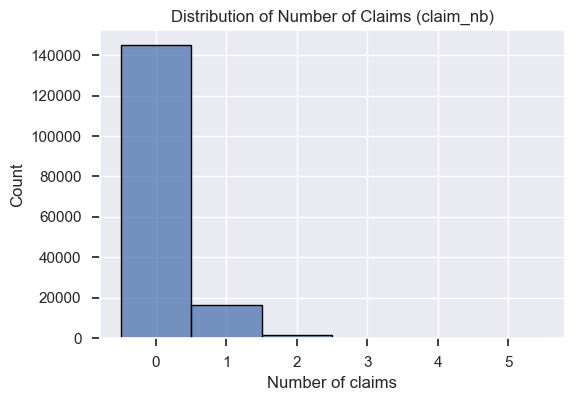

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(df["claim_nb"], bins=30, discrete=True)
plt.title("Distribution of Number of Claims (claim_nb)")
plt.xlabel("Number of claims")
plt.ylabel("Count")
plt.show()


#### 1.3.1.2 Target Variable Analysis: Claim Frequency (`claim_nb`)

The histogram of claim counts highlights the fundamental nature of insurance risk
within the portfolio.

**Key Observations:**
1. **Zero Inflation:** The distribution is highly skewed, with the vast majority of
   policies reporting zero claims. This confirms that claim occurrence is a rare-event
   phenomenon.
2. **Discrete Structure:** Claim counts take only non-negative integer values, with
   frequencies declining rapidly as the number of claims increases.

**Implications for Modeling (Task 4):**
- **Limitations of Linear Models:** The strong concentration of zeros violates the
  assumptions of standard linear regression models, potentially leading to biased
  estimates and invalid (negative) predictions.
- **Appropriate Modeling Framework:** The observed distribution motivates the use of
  count-data models, such as Poisson regression as a baseline, and more flexible
  alternatives (e.g., Negative Binomial or Zero-Inflated Poisson) to address
  over-dispersion and excess zeros.


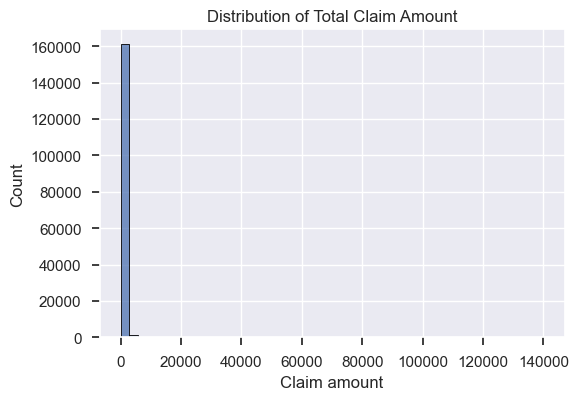

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(df["claim_agg_amount"], bins=50)
plt.title("Distribution of Total Claim Amount")
plt.xlabel("Claim amount")
plt.ylabel("Count")
plt.show()


#### 1.3.1.3 Target Variable Analysis: Claim Severity (`claim_agg_amount`)

The distribution of total claim amounts complements the frequency analysis and
illustrates the financial risk structure of the portfolio.

**Key Observations:**
1. **Extreme Right Skewness:** Similar to claim frequency, this variable is dominated by
   zero values corresponding to policies with no reported claims.
2. **Heavy-Tailed Behavior:** While the mean claim amount is relatively low (~162), the
   maximum observed value reaches approximately 140,000. This indicates the presence
   of rare but extremely costly claims.
3. **Visualization Challenge:** Due to the overwhelming mass at zero, the tail of the
   distribution is barely visible on a standard scale. This pattern is characteristic
   of compound distributions such as Tweedie or Compound Poisson–Gamma models.

**Business and Modeling Implications:**
- **Tail-Driven Risk:** Financial risk in insurance portfolios is driven by extreme
  losses rather than average outcomes. Metrics based solely on mean claim amounts
  therefore provide a misleading representation of risk.
- **Modeling Considerations (Task 4):** Directly modeling `claim_agg_amount` using
  standard linear regression is ill-suited due to non-normality and sensitivity to
  outliers.
- **Recommended Strategy:** In subsequent modeling stages, it is preferable to either
  model claim frequency and claim severity separately or adopt generalized linear
  models with a Tweedie distribution, which naturally accommodates zero mass and
  heavy-tailed positive losses.


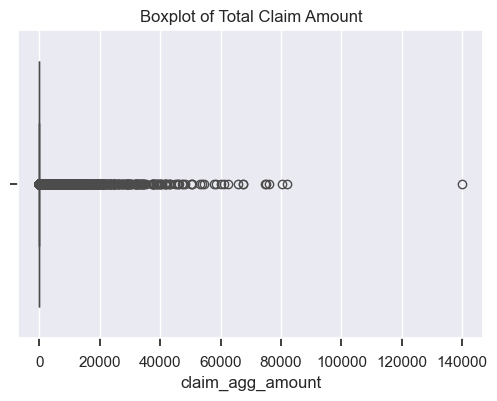

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["claim_agg_amount"])
plt.title("Boxplot of Total Claim Amount")
plt.show()


#### 1.3.1.4 Outlier Analysis: Claim Severity Boxplot

The boxplot of `claim_agg_amount` provides a different perspective on the distribution's extreme skewness, highlighting the limitation of standard statistical visualization for this type of data.

**Visual Interpretation:**
* **Collapsed Box:** The "box" (representing the Interquartile Range, IQR) is essentially collapsed to a single line at 0. This is because the 75th percentile of the data is still **0** (i.e., fewer than 25% of policies have a claim).
* **"Wall" of Outliers:** The plot is dominated by a dense stream of data points extending to the right. In a standard normal distribution, outliers are rare dots beyond the whiskers. Here, **every single claim** is technically classified as an "outlier" because the baseline risk for the majority is zero.

**Business Insight:**
This visualization confirms that "Average" behavior is meaningless for this portfolio. The portfolio dynamics are entirely driven by these "outliers."
* **Segmentation Strategy:** We cannot simply remove these outliers (e.g., using the 1.5*IQR rule) to clean the data. In insurance, these outliers **are** the business. The segmentation model must group customers to isolate the *probability* of becoming such an outlier, rather than treating them as noise.

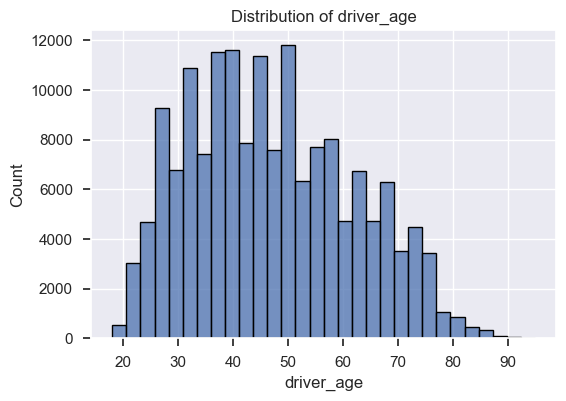

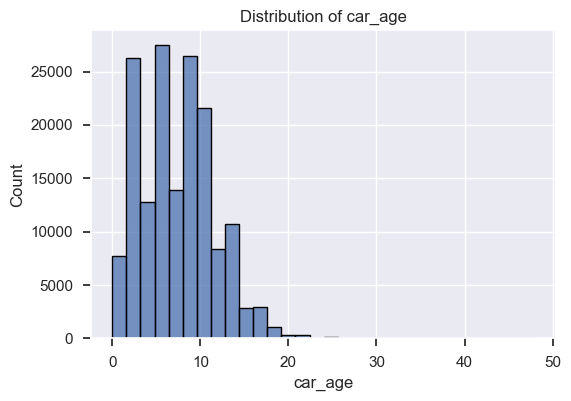

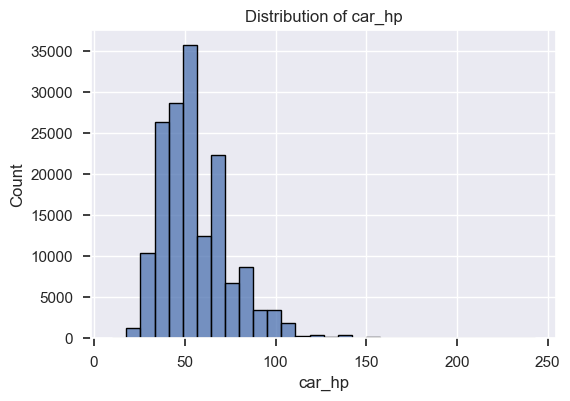

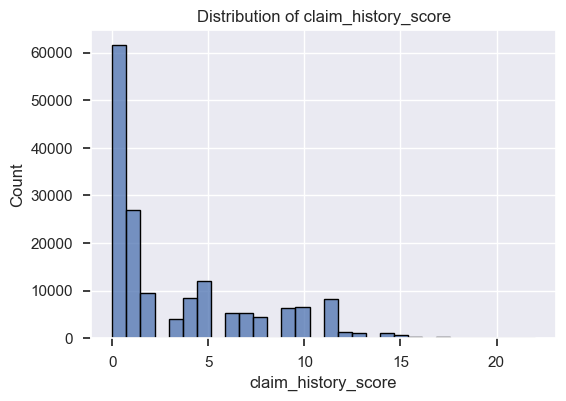

In [11]:
num_vars = ["driver_age", "car_age", "car_hp", "claim_history_score"]

for var in num_vars:
    plt.figure(figsize=(6,4))
    sns.histplot(df[var], bins=30)
    plt.title(f"Distribution of {var}")
    plt.show()


#### 1.3.1.5 Distribution of Key Numerical Risk Factors

The distributions of selected numerical variables provide additional insight into
the heterogeneity of driver and vehicle risk characteristics:

**Driver Age (`driver_age`):**  
The age distribution is unimodal and concentrated between approximately 30 and 60 years.
Very young and very old drivers represent a relatively small share of the portfolio.
This suggests a mature and relatively stable customer base, with age remaining a
relevant but not extreme risk differentiator.

**Vehicle Age (`car_age`):**  
Car age exhibits a right-skewed distribution, with most vehicles being relatively new
(under 10 years old), but a non-negligible tail of older vehicles. Older vehicles may
be associated with higher mechanical failure risk and potentially higher claim
frequency or severity.

**Engine Power (`car_hp`):**  
The distribution of engine horsepower is approximately bell-shaped with a mild right
tail. Most vehicles fall within a moderate power range, while a small subset of
high-powered cars may indicate more aggressive driving behavior and elevated risk
exposure.

**Claim History Score (`claim_history_score`):**  
This variable is highly right-skewed, with the majority of policyholders having low
or zero scores, and a small group exhibiting very high values. This pattern highlights
the strong risk segmentation potential of historical claim behavior, making this
variable particularly informative for customer clustering and risk assessment.


#### 1.3.2 Bivariate Analysis & Relationships
We examine relationships between key features and risk metrics (`claim_nb`, `claim_agg_amount`) to identify potential risk drivers.

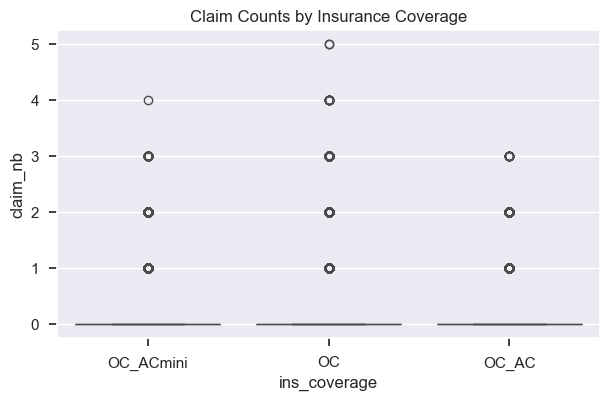

In [12]:
plt.figure(figsize=(7,4))
sns.boxplot(
    data=df, 
    x="ins_coverage", 
    y="claim_nb"
)
plt.title("Claim Counts by Insurance Coverage")
plt.show()


#### 1.3.2.1 Insurance Coverage vs Claim Frequency

The boxplot analysis compares claim counts across different insurance coverage types, revealing subtle but important differences in risk profiles.

**Visual Interpretation:**
* **Median at Zero:** Across all coverage levels (`OC`, `OC_ACmini`, `OC_AC`), the median number of claims remains zero. This reconfirms the dominant zero-inflation pattern across the entire portfolio.
* **Tail Behavior:** However, policies with broader coverage (specifically `OC_AC`) exhibit a wider range of outliers in the upper quantiles, indicating a higher probability of multiple claims compared to basic coverage.

**Business Interpretation:**
This pattern is likely driven by a combination of factors:
1.  **Scope of Coverage:** `OC_AC` covers a wider array of perils (e.g., theft, own damage) than basic `OC`, naturally leading to more reportable events.
2.  **Self-Selection (Adverse Selection):** Customers who perceive themselves as higher risk (or own more expensive vehicles) are more likely to opt for comprehensive coverage.
3.  **Moral Hazard:** Policyholders with full coverage may be more inclined to file claims for minor damages that those with basic coverage would pay out-of-pocket or ignore.

**Conclusion:**
Consequently, `ins_coverage` is not just a contractual label but a powerful proxy for customer risk behavior, making it a valid candidate for segmentation.

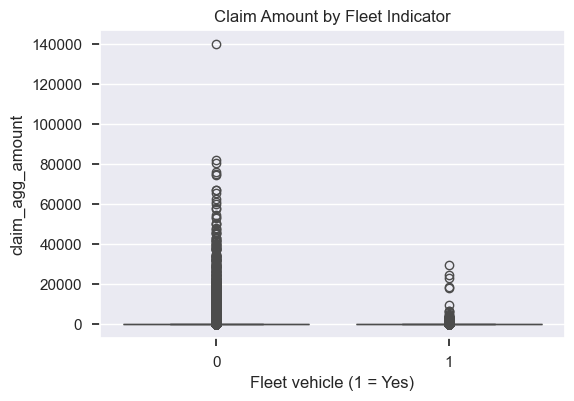

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x="car_is_fleet",
    y="claim_agg_amount"
)
plt.title("Claim Amount by Fleet Indicator")
plt.xlabel("Fleet vehicle (1 = Yes)")
plt.show()


#### 1.3.2.2 Fleet Status vs Claim Severity

The boxplot highlights a notable contrast in claim severity dynamics between fleet and non-fleet vehicles.

**Visual Interpretation:**
* **Outlier Dominance in Non-Fleets:** Non-fleet vehicles (`car_is_fleet = 0`) exhibit a much wider range of outliers, including the largest observed claim amounts in the dataset.
* **Controlled Severity in Fleets:** Fleet vehicles (`car_is_fleet = 1`) show a comparatively narrower distribution of positive claim amounts.

**Business & Statistical Interpretation:**
1.  **Sample Size Effect:** It is important to note that non-fleet vehicles constitute ~97% of the portfolio. Statistically, extreme tail events (outliers) are naturally more likely to appear in the larger sub-population.
2.  **Operational Factors:** Even accounting for sample size, the "narrower" severity distribution for fleets likely reflects professional fleet management, standardized repair contracts, or bulk insurance policies that cap per-claim payouts.
3.  **Risk Profile:** Although fleet vehicles often have higher usage frequency (mileage), their per-accident cost appears more predictable.

**Modeling Implication:**
Fleet status is a meaningful categorical variable. Its distinct distribution suggests it may interact differently with claim severity compared to private cars, confirming the need to include `car_is_fleet` as a predictor in the final GLM models.

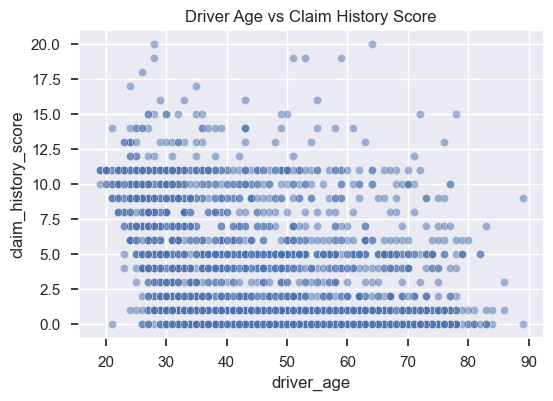

In [14]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df.sample(3000, random_state=42),
    x="driver_age",
    y="claim_history_score",
    alpha=0.5
)
plt.title("Driver Age vs Claim History Score")
plt.show()


#### 1.3.2.3 Driver Age vs Claim History Score

The scatter plot reveals no strong linear relationship between driver age and claim history score, challenging the assumption that age alone is a direct predictor of history.

**Visual Interpretation:**
* **Dispersion Variance:** Younger drivers display greater dispersion in their scores. This indicates a high degree of volatility in this segment—while some are cautious, others rapidly accumulate poor history.
* **Convergence with Age:** As driver age increases, the variability in claim history generally decreases. Older drivers tend to settle into more stable, predictable risk patterns.

**Business & Modeling Insight:**
* **Experience Factor:** This pattern suggests that `driver_age` acts as a proxy for **driving experience** and **maturity**. The initial years of driving are a "discovery phase" characterized by high variance.
* **Non-Linearity:** The relationship is clearly non-monotonic. Consequently, treating Age as a simple linear variable in the predictive model would be suboptimal. We recommend using **Age Bands (Binning)** or **Polynomial features** (e.g., Age²) to capture this non-linear risk heterogeneity effectively.


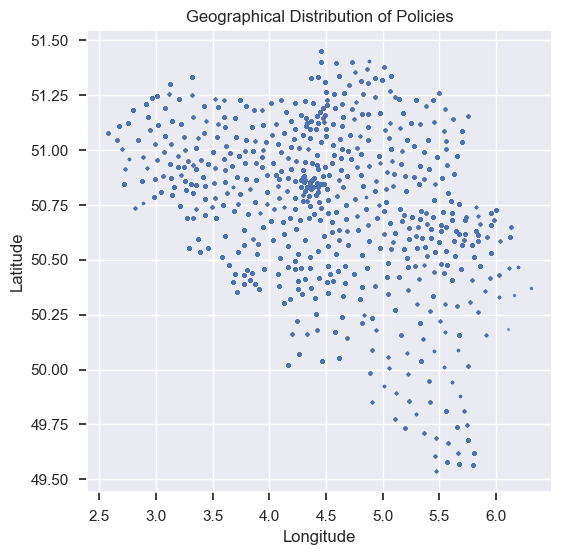

In [15]:
plt.figure(figsize=(6,6))
plt.scatter(
    df["geo_long"], 
    df["geo_lat"], 
    s=2, 
    alpha=0.3
)
plt.title("Geographical Distribution of Policies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


#### 1.3.2.4 Geographical Distribution of Policies

The spatial scatter plot visualizes the geographic footprint of the portfolio based on latitude and longitude coordinates.

**Visual Interpretation:**
* **Geographic Identity:** The coordinate range (Lat ~50, Long ~4) and the distinct shape strongly suggest the data covers **Belgium**.
* **Density Clustering:** The distribution is not uniform. We observe a high-density cluster in the center (likely **Brussels** and surrounding metropolitan areas) and higher density in the north (Flanders) compared to the sparser southern region (Wallonia).

**Business & Modeling Insight:**
* **Urban vs. Rural Dynamics:** This clustering highlights the need to differentiate between urban and rural risks. Urban areas (high density) typically correlate with higher claim **frequency** due to traffic congestion, while rural areas may be associated with higher **severity** (due to higher speeds).
* **Proxy for External Factors:** Location acts as a powerful composite variable capturing traffic density, road quality, and local weather patterns.
* **Modeling Strategy:** Since raw coordinates can be noisy, we recommend exploring **spatial binning**, using the postal code (`geo_postal`), or creating a "distance to city center" feature to capture these underlying risk gradients in the model.

### 1.4 Feature Engineering Justification

Based on the insights from our EDA, we implemented the following transformations to better capture risk patterns:

1.  **`geo_region` (Dimensionality Reduction):**
    * *Reasoning:* The raw `geo_postal` variable has high cardinality. By truncating it to the **first 2 digits** (as implemented in the code), we aggregate policyholders into broader administrative regions (e.g., Provinces), capturing regional risk without overfitting.

2.  **`car_age_bin` & `car_hp_bin` (Non-Linearity Handling):**
    * *Reasoning:* Risk does not scale linearly. We discretized these variables based on business logic:
        * **Car Age:** Grouped into lifecycle stages: **'New' (0-3 yrs)**, **'Medium' (3-6 yrs)**, **'Old' (6-10 yrs)**, and **'Very Old' (10+ yrs)**.
        * **Horsepower:** Segmented into **'Low' (<60 hp)**, **'Medium' (60-90 hp)**, **'High' (90-120 hp)**, and **'Very High' (>120 hp)**.

3.  **`usage_category` (Interaction Feature):**
    * *Reasoning:* As noted in EDA, `car_is_fleet` and `car_usage` are highly imbalanced. We created a combined text feature (e.g., **`Private_private`**, **`Fleet_work`**) to explicitly isolate distinct risk profiles, such as commercial fleet usage versus personal private usage, which might otherwise be lost if treated independently.
      
Overall, these transformations aim to reduce dimensionality, capture non-linear
risk effects, and make latent interactions explicit, thereby improving both
model interpretability and segmentation stability in downstream tasks.


In [16]:
# --- 1. Feature Engineering (Vectorized) ---

# [New Feature 1] Geo Region

df['geo_region'] = df['geo_postal'].astype(str).str[:2]

# [New Feature 2] Car Age Bin

df['car_age_bin'] = pd.cut(
    df['car_age'], 
    bins=[-1, 3, 6, 10, 100], 
    labels=['New', 'Medium', 'Old', 'Very Old']
)

# [New Feature 3] Car Power Bin

df['car_hp_bin'] = pd.cut(
    df['car_hp'], 
    bins=[-1, 60, 90, 120, 1000], 
    labels=['Low', 'Medium', 'High', 'Very High']
)

# [New Feature 4] Usage_Fleet 

df['usage_category'] = np.where(
    df['car_is_fleet'] == 1,
    'Fleet_' + df['car_usage'],
    'Private_' + df['car_usage']
)

print("Feature Engineering Completed. New columns added:")
print(df[['geo_region', 'car_age_bin', 'car_hp_bin', 'usage_category']].head())

Feature Engineering Completed. New columns added:
  geo_region car_age_bin car_hp_bin   usage_category
0         71      Medium        Low  Private_private
1         44    Very Old        Low  Private_private
2         70         New        Low  Private_private
3         55    Very Old        Low  Private_private
4         17      Medium     Medium  Private_private


### 1.5 Variable Selection for Segmentation
Based on the EDA and feature engineering, we select the subset of variables to be used for the **K-Means Segmentation Model** in Part 2.

**Selection Criteria:**
1.  **Relevance:** Variables must describe the *customer* or the *asset* (policyholder profile), not the outcome (claims).
2.  **Redundancy:** We analyze the correlation matrix to avoid multicollinearity.

**Correlation Analysis:**
(See Heatmap below)

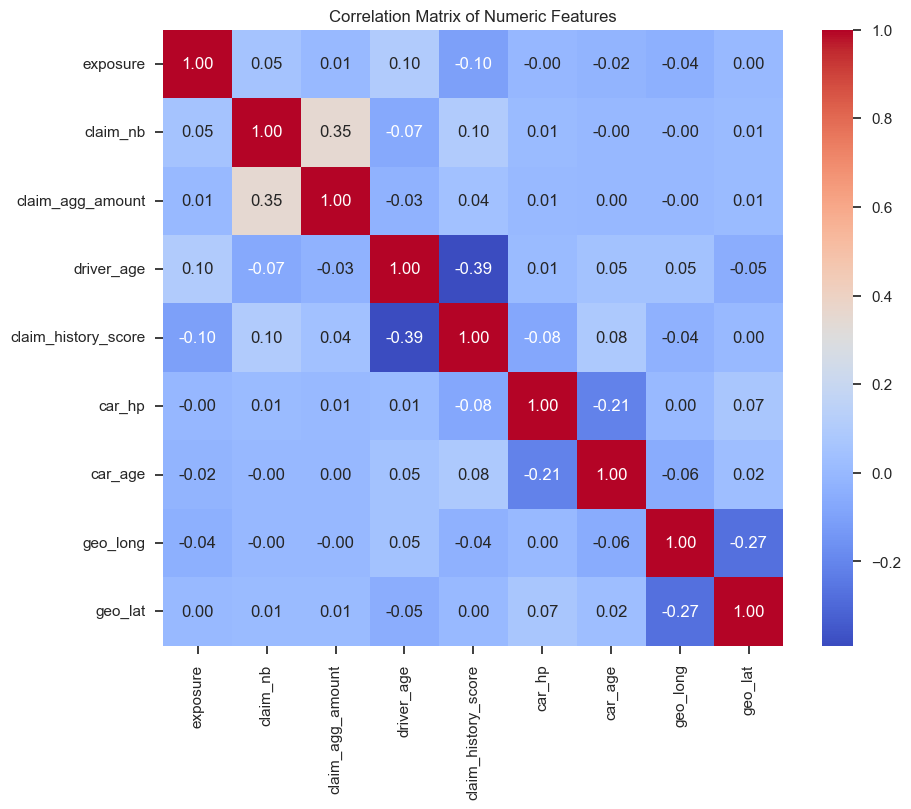


=== Final set of features selected for clustering ===
['driver_age', 'claim_history_score', 'car_hp', 'car_age', 'geo_long', 'geo_lat']

Rationale: These features jointly capture driver profile, historical risk, vehicle characteristics, and geographical location, while maintaining acceptable levels of multicollinearity.


In [17]:
# --- 2. Variable Selection ---

# Step 1: Compute the correlation matrix to identify and remove highly correlated (redundant) variables
plt.figure(figsize=(10, 8))

# Select numeric variables only for correlation analysis
numeric_cols = [
    'exposure', 'claim_nb', 'claim_agg_amount', 'driver_age',
    'claim_history_score', 'car_hp', 'car_age', 'geo_long', 'geo_lat'
]

corr_matrix = df[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

# Step 2: Select variables for clustering (Segmentation)
# Rationale:
# 1. Although 'car_age' and 'car_hp' were binned during feature engineering,
#    using their original numerical values often preserves more information in K-Means clustering.
#    Additionally, K-Means may perform poorly on high-dimensional sparse matrices
#    generated by one-hot encoding of binned variables.
# 2. 'driver_age' (driver characteristics), 'claim_history_score' (historical risk),
#    and 'car_age' & 'car_hp' (vehicle characteristics) are essential risk drivers.
# 3. 'geo_long' and 'geo_lat' capture geographical risk patterns and are therefore critical.
# 4. 'exposure' is typically used as a weight rather than a clustering feature.
# 5. 'claim_nb' and 'claim_agg_amount' are target variables and should not be used
#    as clustering inputs, as this would result in outcome-driven segmentation.

selected_features_for_clustering = [
    'driver_age',
    'claim_history_score',
    'car_hp',
    'car_age',
    'geo_long',
    'geo_lat'
]

print("\n=== Final set of features selected for clustering ===")
print(selected_features_for_clustering)
print(
    "\nRationale: These features jointly capture driver profile, historical risk, "
    "vehicle characteristics, and geographical location, while maintaining acceptable "
    "levels of multicollinearity."
)


#### 1.5 Final Variable Selection for Segmentation

Based on the EDA, correlation analysis, and feature engineering performed above, we have finalized the set of variables to be used for the K-Means clustering model in Task 2.

**Selected Variables:**
We selected the following **6 features** to build the customer profiles:

1.  **`driver_age`** (Driver Profile):
    * *Reason:* Age is a primary determinant of risk appetite and driving experience. Young drivers and senior drivers often have distinct risk profiles.
2.  **`claim_history_score`** (Driver History):
    * *Reason:* This score serves as a direct proxy for past driving behavior and riskiness. It differentiates "safe" drivers from "high-risk" ones regardless of their age.
3.  **`car_hp`** (Vehicle Characteristic):
    * *Reason:* Engine power correlates with the type of vehicle (sports car vs. city car) and potential accident severity.
4.  **`car_age`** (Vehicle Characteristic):
    * *Reason:* Distinguishes between owners of new, high-value vehicles (often needing Casco) and older, depreciated vehicles.
5.  **`geo_long` & `geo_lat`** (Location):
    * *Reason:* Insurance risk is highly location-dependent (urban vs. rural, traffic density). Using coordinates allows the model to spatially cluster customers without needing high-cardinality postal codes.

**Excluded Variables:**
* **`claim_nb` & `claim_agg_amount`:** Excluded because these are *outcomes* (post-event), not *attributes* (pre-event). We want to segment customers based on who they *are*, not just how many claims they had this specific year.
* **`ins_coverage`:** Excluded from the core clustering to see if the derived risk groups naturally align with specific product choices.
* **Highly Correlated Variables:** We avoided using both `car_age` and `car_age_bin` simultaneously to prevent multicollinearity issues in K-Means (Euclidean distance distortion).

**Conclusion:**
This subset of variables provides a balanced view of the **Driver**, the **Vehicle**, and the **Location**, creating a solid foundation for multi-dimensional segmentation.

# Part 2: Building the Segmentation Model (K-means)

## 2.1 Objective and Overview

In this part, we build a customer segmentation model using the K-means clustering algorithm. Based on the selected risk-related variables from Part 1, we apply appropriate preprocessing steps to ensure K-means performs reliably under Euclidean distance. We then determine the optimal number of clusters using two different criteria (Elbow/Inertia and Silhouette score), and justify the choice of cluster initialization strategy.

## 2.2 Feature Selection for Clustering

We use a set of continuous risk drivers identified in Part 1 (e.g., driver age, vehicle characteristics, and claim history score). Outcome variables such as claim_nb and claim_agg_amount are not included in the clustering inputs to avoid creating clusters driven purely by historical losses. Geographic variables (geo_long, geo_lat) are evaluated separately to check whether segmentation becomes overly location-driven.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [19]:
# Choose features
# Baseline numeric risk features (from Part 1 conclusion)
num_features_base = ["driver_age", "claim_history_score", "car_hp", "car_age"]

# Geography features (optional; we will compare with/without geo)
geo_features = ["geo_long", "geo_lat"]

# Optional categorical features (set if you want to include them; requires One-Hot)
# Example: cat_features = ["car_usage", "car_fuel"]
cat_features = []

## 2.3 Preprocessing Strategy (Two Schemes)

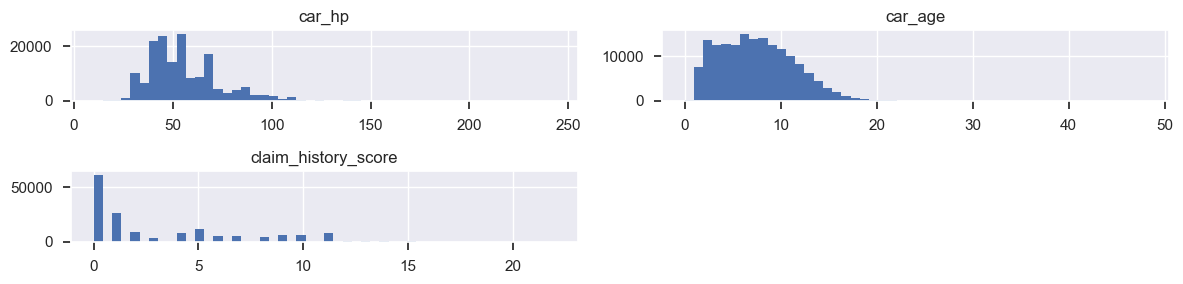

In [20]:
ax = df[["car_hp","car_age","claim_history_score"]].hist(bins=50, figsize=(12,3))
plt.tight_layout()
plt.show()

K-means relies on Euclidean distance, which means two practical issues can strongly distort the clustering results: outliers and scale differences. If a small number of observations contain extremely large values (e.g., unusually high car_hp or very old car_age), these points can dominate distance calculations and pull cluster centroids toward them. To mitigate this, we apply winsorization by clipping selected numeric variables to the 1st and 99th percentiles, reducing the influence of extreme tails while preserving the majority of the distribution.

In addition, claim_history_score shows a strong right-skewed distribution (long right tail), where a large share of policies have very low scores (often near 0–2), but a smaller group has much higher values extending to the upper end. This creates an uneven distance structure: differences among high-score observations can become disproportionately large compared to differences in the main mass of the data. To address this, we consider a log1p transformation on claim_history_score (after winsorization). The log1p transform compresses the upper tail while keeping zero values valid (since log1p(0)=0), leading to a more balanced contribution of this feature in Euclidean space.

We therefore evaluate two preprocessing schemes:

- **S1 (Baseline):**  Winsorization (1%–99%) + Standardization (StandardScaler)
    This setup reduces outlier impact and ensures all numeric variables contribute comparably to distance computations.
- **S2 (Enhanced):**  Winsorization (1%–99%) + log1p(claim_history_score) + Standardization
    
This setup further addresses the pronounced right-skewness of claim_history_score by reducing tail dominance and making distances less sensitive to extreme claim history values.

Both schemes are compared using clustering quality metrics (Elbow/Inertia and Silhouette score) to determine whether the additional skewness correction in S2 improves separation and stability of the resulting segments.

### Implementation note. 

The two schemes are implemented via a data preparation function and a scikit-learn pipeline. The function prepare_data_for_kmeans() applies winsorization and optionally log1p to claim_history_score (S2). The pipeline build_kmeans_pipeline() standardizes numeric variables (and optionally one-hot encodes categorical variables) before fitting K-means. The same pipeline is reused across all experiments to ensure a fair comparison.

In [21]:
# Preprocessing: winsorize + optional log1p(history_score)
def prepare_data_for_kmeans(df, num_features, cat_features,
                            winsor_cols=None,
                            log_history=False,
                            q_low=0.01, q_high=0.99):

    used_cols = list(num_features) + list(cat_features)
    data = df[used_cols].copy().dropna()

    if winsor_cols is None:
        winsor_cols = []

    # Winsorization (clip extremes) to reduce outlier influence in K-means
    for c in winsor_cols:
        if c in data.columns:
            lo, hi = data[c].quantile([q_low, q_high])
            data[c] = data[c].clip(lo, hi)

    # Optional log1p transformation for strongly right-skewed claim_history_score
    if log_history and "claim_history_score" in data.columns:
        data["claim_history_score"] = np.log1p(data["claim_history_score"].clip(lower=0))

    return data


In [22]:
# Build a K-means pipeline (scaling + optional one-hot + KMeans)
def build_kmeans_pipeline(num_features, cat_features, k,
                          random_state=42, n_init=50, max_iter=500):

    transformers = []

    if len(num_features) > 0:
        transformers.append(("num", StandardScaler(), num_features))

    if len(cat_features) > 0:
        transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_features))

    preprocess = ColumnTransformer(transformers=transformers, remainder="drop")

    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=n_init,
        max_iter=max_iter,
        random_state=random_state
    )

    model = Pipeline(steps=[
        ("prep", preprocess),
        ("kmeans", km)
    ])
    return model

## 2.4 Choosing the Optimal Number of Clusters (k)

To determine the optimal number of clusters, we evaluate **k = 2 to 8** using two complementary criteria:

- **Elbow method (Inertia / SSE):** identifies the point where adding more clusters yields diminishing returns in reducing within-cluster sum of squares.
- **Silhouette score:** measures both within-cluster cohesion and between-cluster separation (higher is better).

We compare four configurations formed by:
- **Feature sets:**  
  **A** = Risk-only (driver_age, claim_history_score, car_hp, car_age)  
  **B** = Risk + Geo (A + geo_long, geo_lat)
- **Preprocessing schemes:**  
  **S1** = Winsorization (1%–99%) + StandardScaler  
  **S2** = Winsorization (1%–99%) + log1p(claim_history_score) + StandardScaler

In [23]:
# Define winsor columns
winsor_cols = ["claim_history_score", "car_hp", "car_age"]

In [24]:
# Evaluate k range by Elbow (inertia) + Silhouette
def evaluate_k_range_prepared(data, num_features, cat_features,
                              k_min=2, k_max=8, random_state=42,
                              n_init=10, max_iter=300):
    
    ks = list(range(k_min, k_max + 1))
    inertias, silhouettes = [], []

    for k in tqdm(ks, desc="k loop", leave=False):
        model = build_kmeans_pipeline(
            num_features=num_features,
            cat_features=cat_features,
            k=k,
            random_state=random_state,
            n_init=n_init,
            max_iter=max_iter
        )
        model.fit(data)

        inertias.append(model.named_steps["kmeans"].inertia_)

        X_trans = model.named_steps["prep"].transform(data)
        labels = model.named_steps["kmeans"].labels_
        silhouettes.append(silhouette_score(X_trans, labels))

    return ks, inertias, silhouettes


def plot_k_selection(ks, inertias, silhouettes, title_prefix="Model"):
    plt.figure()
    plt.plot(ks, inertias, marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (SSE)")
    plt.title(f"{title_prefix}: Elbow Method (Inertia)")
    plt.show()

    plt.figure()
    plt.plot(ks, silhouettes, marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette score")
    plt.title(f"{title_prefix}: Silhouette Scores")
    plt.show()

In [25]:
# Define experiments (A/B × S1/S2)
experiments = [
    {"name": "A-S1 (Risk-only, winsorize+scale)",
     "num": num_features_base, "cat": cat_features, "log_history": False},

    {"name": "A-S2 (Risk-only, winsorize+log1p(history)+scale)",
     "num": num_features_base, "cat": cat_features, "log_history": True},

    {"name": "B-S1 (Risk+Geo, winsorize+scale)",
     "num": num_features_base + geo_features, "cat": cat_features, "log_history": False},

    {"name": "B-S2 (Risk+Geo, winsorize+log1p(history)+scale)",
     "num": num_features_base + geo_features, "cat": cat_features, "log_history": True},
]


>>> Running experiments for k selection ...


Experiments:   0%|                                        | 0/4 [00:00<?, ?it/s]


Running A-S1 (Risk-only, winsorize+scale) ...
  Full prepared shape: (163212, 4), eval sample: (48964, 4)



oop: 100%|█████████████████████████████████████| 7/7 [01:24<00:00, 10.94s/it]
                                                                             

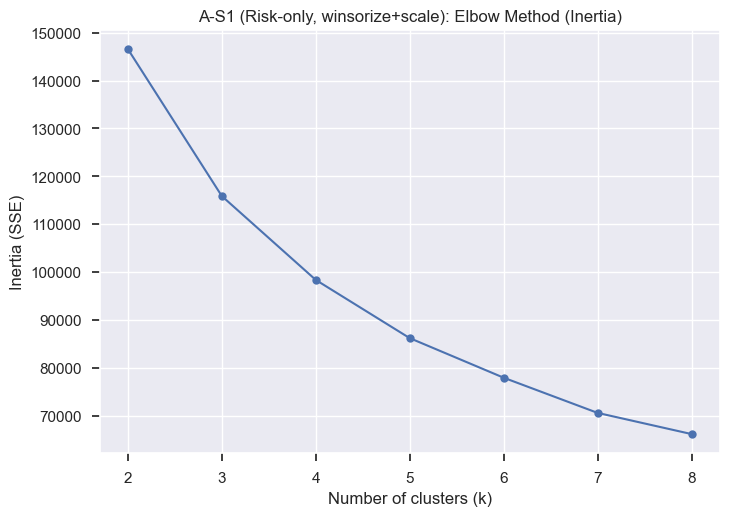

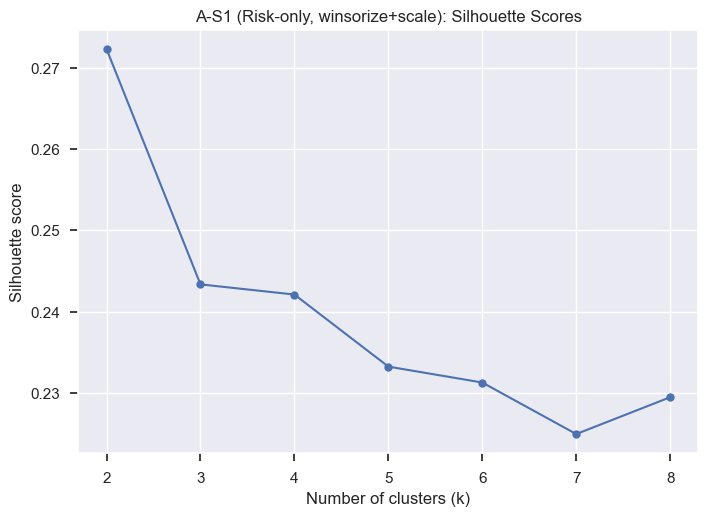

  DONE: best k (by silhouette) = 2, best silhouette = 0.2723


Experiments:  25%|████████                        | 1/4 [01:24<04:13, 84.55s/it]


Running A-S2 (Risk-only, winsorize+log1p(history)+scale) ...
  Full prepared shape: (163212, 4), eval sample: (48964, 4)



oop: 100%|█████████████████████████████████████| 7/7 [01:21<00:00, 10.70s/it]
                                                                             

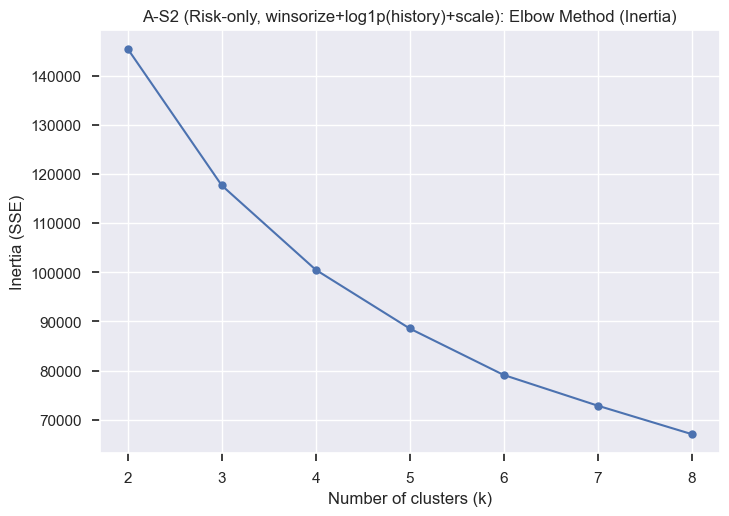

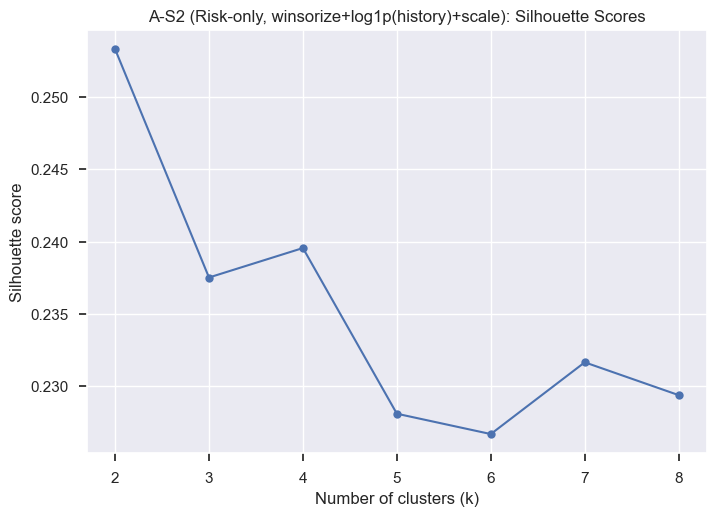

  DONE: best k (by silhouette) = 2, best silhouette = 0.2533


Experiments:  50%|████████████████                | 2/4 [02:45<02:45, 82.63s/it]


Running B-S1 (Risk+Geo, winsorize+scale) ...
  Full prepared shape: (163212, 6), eval sample: (48964, 6)



oop: 100%|█████████████████████████████████████| 7/7 [01:22<00:00, 10.89s/it]
                                                                             

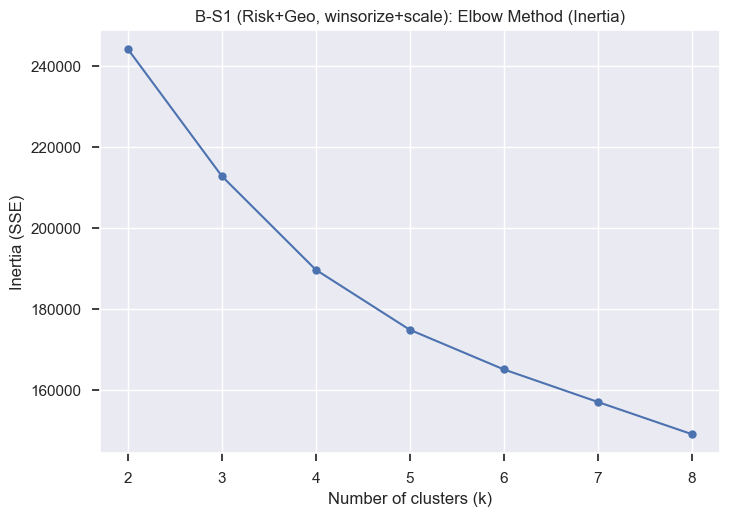

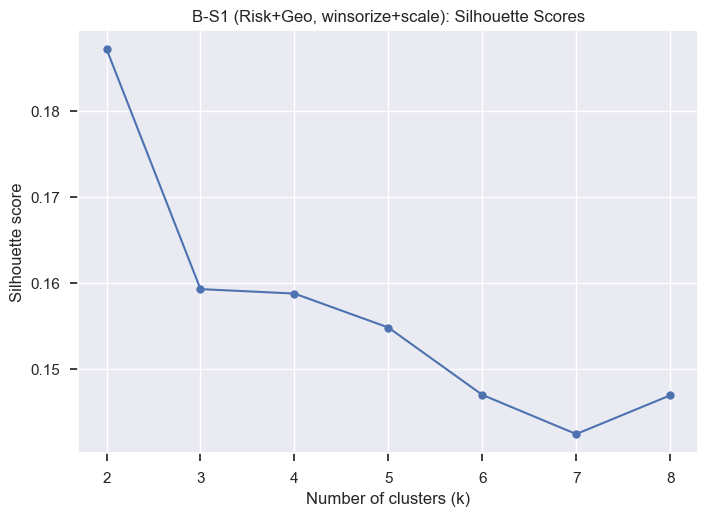

  DONE: best k (by silhouette) = 2, best silhouette = 0.1872


Experiments:  75%|████████████████████████        | 3/4 [04:08<01:22, 82.78s/it]


Running B-S2 (Risk+Geo, winsorize+log1p(history)+scale) ...
  Full prepared shape: (163212, 6), eval sample: (48964, 6)



oop: 100%|█████████████████████████████████████| 7/7 [01:22<00:00, 10.87s/it]
                                                                             

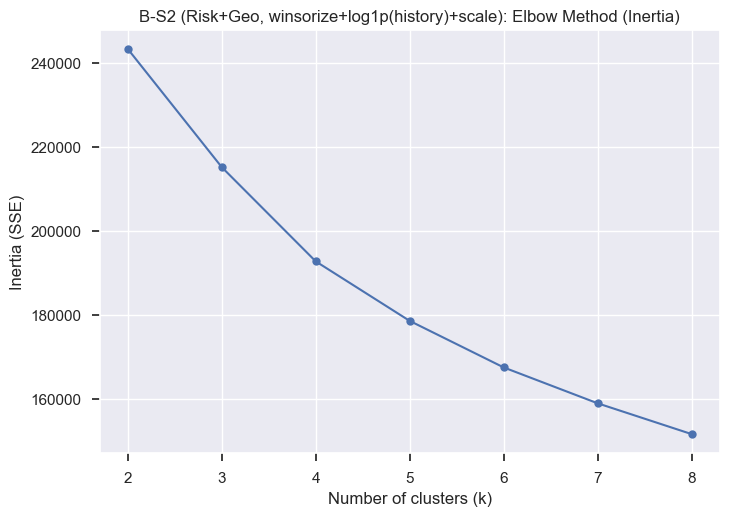

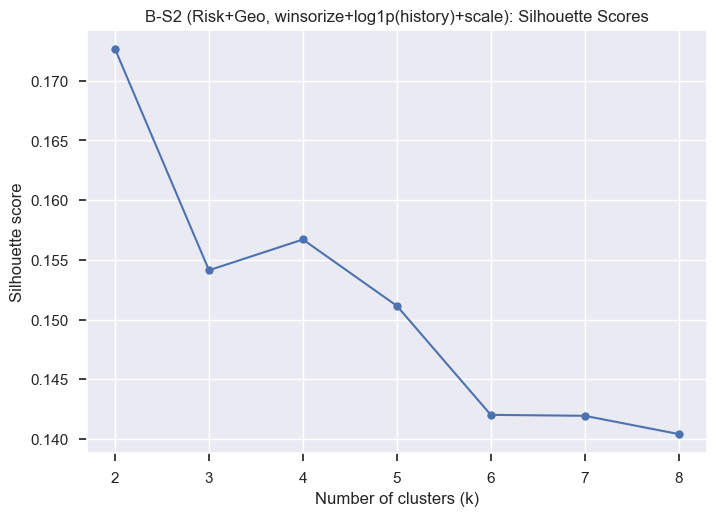

  DONE: best k (by silhouette) = 2, best silhouette = 0.1727


Experiments: 100%|████████████████████████████████| 4/4 [05:31<00:00, 82.87s/it]


>>> k selection experiments finished.


In [26]:
# Run experiments to choose k
results = {}

print(">>> Running experiments for k selection ...", flush=True)

for exp in tqdm(experiments, desc="Experiments", leave=True):
    print(f"\nRunning {exp['name']} ...", flush=True)

    # Prepare full data (winsorize + optional log)
    data_prepared = prepare_data_for_kmeans(
        df=df,
        num_features=exp["num"],
        cat_features=exp["cat"],
        winsor_cols=winsor_cols,
        log_history=exp["log_history"],
        q_low=0.01,
        q_high=0.99
    )

    # Optional sampling for faster k selection (set frac=1.0 to disable)
    frac = 0.3
    data_eval = data_prepared.sample(frac=frac, random_state=42) if frac < 1.0 else data_prepared
    print(f"  Full prepared shape: {data_prepared.shape}, eval sample: {data_eval.shape}", flush=True)
    
    '''
    # Full-data k-selection is very slow (especially silhouette), but results were consistent
    data_eval = data_prepared
    print(f"  Using full prepared data for k selection: {data_eval.shape}", flush=True)
    '''
    
    # Evaluate k (FAST)
    ks, inertias, silhouettes = evaluate_k_range_prepared(
        data=data_eval,
        num_features=exp["num"],
        cat_features=exp["cat"],
        k_min=2,
        k_max=8,
        random_state=42,
        n_init=10,
        max_iter=300
    )

    best_idx = int(np.argmax(silhouettes))
    best_k = ks[best_idx]
    best_sil = float(silhouettes[best_idx])

    results[exp["name"]] = {
        "data_prepared_full": data_prepared,  # keep FULL data for final fit
        "num": exp["num"],
        "cat": exp["cat"],
        "log_history": exp["log_history"],
        "ks": ks,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "best_k": best_k,
        "best_silhouette": best_sil
    }

    plot_k_selection(ks, inertias, silhouettes, title_prefix=exp["name"])
    print(f"  DONE: best k (by silhouette) = {best_k}, best silhouette = {best_sil:.4f}", flush=True)

print("\n>>> k selection experiments finished.", flush=True)

In [28]:
summary = pd.DataFrame([
    {"config": k, 
     "best_k": v["best_k"], 
     "best_silhouette": v["best_silhouette"],
     "n_features": len(v["num"]) + len(v["cat"])}
    for k, v in results.items()
]).sort_values("best_silhouette", ascending=False)

summary

,config,best_k,best_silhouette,n_features
0,"A-S1 (Risk-only, winsorize+scale)",2,0.272271,4
1,"A-S2 (Risk-only, winsorize+log1p(history)+scale)",2,0.253312,4
2,"B-S1 (Risk+Geo, winsorize+scale)",2,0.187220,6
3,"B-S2 (Risk+Geo, winsorize+log1p(history)+scale)",2,0.172656,6


### Note on sampling for k-selection (computational efficiency)

Evaluating K-means over multiple values of *k* and multiple configurations is computationally expensive on the full dataset (163,212 observations), especially because the silhouette score is costly to compute. Therefore, we initially performed k-selection on a **30% random subsample** to reduce runtime.

To ensure this approximation does not bias the decision, we also repeated the same k-selection procedure on the **full dataset**. The results were essentially unchanged: in all configurations the best silhouette was still obtained at **k = 2**, and **A-S1** remained the best-performing configuration. This consistency indicates that the chosen solution is **stable**, so we keep subsampling for efficiency during model selection and then fit the **final model on the full prepared dataset**.

### Note on using two methods to justify *k*

We justify the choice of *k* using **two complementary methods**: the **Elbow method (inertia/SSE)** and the **Silhouette score**.  
The Elbow curve shows inertia decreasing monotonically as *k* increases (as expected), without a very sharp elbow. However, the curve becomes progressively flatter for larger *k*, indicating **diminishing marginal gains** and suggesting that the number of clusters should not be too large.

Given the smooth elbow pattern, we rely primarily on the **Silhouette score** for the final decision. The silhouette reaches its maximum at **k = 2** (≈ **0.2723**), indicating the best separation and cohesion among the tested values. From a business perspective, two segments are also highly interpretable and actionable (e.g., **lower-risk vs. higher-risk** customers). Therefore, combining the silhouette peak, the elbow’s diminishing-returns pattern, and business interpretability, we choose **k = 2**.

### 2.4.1 Visual inspection (Elbow + Silhouette)

Below we report the Elbow (inertia) and Silhouette curves for each configuration.

**A-S1 (Risk-only, winsorize + scale)**  
- *Elbow plot:* inertia decreases sharply at small k and then flattens gradually, indicating diminishing returns after a small number of clusters.  
- *Silhouette plot:* the highest silhouette is at **k = 2**, followed by a clear drop for k ≥ 3, suggesting the best separation occurs with two clusters.

**A-S2 (Risk-only, winsorize + log1p(history) + scale)**  
- *Elbow plot:* similar shape to A-S1 (monotonic decrease with diminishing returns).  
- *Silhouette plot:* again peaks at **k = 2**, with lower values for larger k.

**B-S1 (Risk + Geo, winsorize + scale)**  
- *Elbow plot:* inertia decreases as expected with k, but without a strong improvement beyond small k.  
- *Silhouette plot:* the peak is at **k = 2**, but overall scores are noticeably lower than the risk-only case, indicating weaker separation when geographic coordinates are included.

**B-S2 (Risk + Geo, winsorize + log1p(history) + scale)**  
- *Elbow plot:* similar diminishing-return behavior.  
- *Silhouette plot:* highest at **k = 2**, but again with the lowest overall separation among the four configurations.

Overall, **both methods consistently point to a small number of clusters**, and the **Silhouette criterion clearly selects k = 2** in all configurations.

---

### 2.4.2 Quantitative comparison across configurations

The best k values (by silhouette) and the corresponding silhouette scores are:

| Configuration | Feature set | Preprocessing | Best k (Silhouette) | Best Silhouette |
|---|---|---|---:|---:|
| A-S1 | Risk-only | winsorize + scale | 2 | **0.2723** |
| A-S2 | Risk-only | winsorize + log1p(history) + scale | 2 | 0.2533 |
| B-S1 | Risk + Geo | winsorize + scale | 2 | 0.1872 |
| B-S2 | Risk + Geo | winsorize + log1p(history) + scale | 2 | 0.1727 |

**Key observations:**
1. **k = 2 is the optimal choice in all four configurations**, indicating a stable preference for two segments.
2. **Risk-only models (A) outperform models that include geography (B)**: adding geo_long/geo_lat substantially lowers silhouette scores (≈0.17–0.19 vs. ≈0.25–0.27), meaning clusters become less well-separated when geography is included.
3. **The log1p transformation (S2) does not improve clustering quality**: within both A and B, S2 yields lower silhouettes than S1, suggesting that winsorization + scaling already provides sufficient robustness, and further compression of claim_history_score reduces useful variation for segmentation.

---

### 2.4.3 Final decision

Based on **(i) the consistent Silhouette peak at k = 2** and **(ii) diminishing returns in inertia reduction (Elbow)**, we select:

- **Final number of clusters:** **k = 2**
- **Final configuration:** **A-S1 (Risk-only, winsorization + StandardScaler)**

This configuration provides the **highest silhouette score (0.2723)**, indicating the best balance of compact clusters and clear separation, while remaining interpretable as a **risk-based segmentation** rather than geographic grouping.

## 2.5 Initialization Strategy

K-means can converge to different solutions depending on the **initial centroid positions**, because the optimization problem is non-convex and may get trapped in a **local minimum**. To improve stability and reduce sensitivity to initialization, we apply two strategies:

- **k-means++ initialization:** spreads initial centroids farther apart than random initialization, which typically improves convergence quality and stability.
- **Multiple random restarts (`n_init`):** runs K-means multiple times with different initializations and selects the best solution based on the **lowest inertia (SSE)**.

In our workflow, we use a **smaller `n_init` during k-selection** (for computational efficiency), and then **refit the final model on the full dataset** with a **larger `n_init`** to obtain a stable final segmentation.

## 2.6 Final Model Fitting (K-means)

Based on Section 2.4, we choose:

- **Final configuration:** **A-S1 (Risk-only, winsorize + scale)**
- **Final number of clusters:** **k = 2**

In this section, we refit the final K-means model on the **full prepared dataset** (not the sampling subset used for k-selection), using a larger `n_init` to ensure stability. The resulting cluster labels are then merged back into the original dataset for the next step (cluster profiling in Task 3).

In [29]:
# 2.6 Final Model Fitting (K-means) 
# Explicitly set final choice based on your results
#    From experiments:
#    A-S1 silhouette = 0.2723 (best overall), best k = 2
final_exp_name = "A-S1 (Risk-only, winsorize+scale)"
final_k = 2

print("Final configuration:", final_exp_name)
print("Final k:", final_k)

Final configuration: A-S1 (Risk-only, winsorize+scale)
Final k: 2


In [30]:
# Rebuild the FULL prepared dataset for the final configuration
#    (important: use full data, not evaluation sample)
final_num = num_features_base
final_cat = cat_features
final_log_history = False  # S1 => no log1p

final_data_full = prepare_data_for_kmeans(
    df=df,
    num_features=final_num,
    cat_features=final_cat,
    winsor_cols=winsor_cols,
    log_history=final_log_history,
    q_low=0.01,
    q_high=0.99
)

print("Full prepared data shape:", final_data_full.shape)

Full prepared data shape: (163212, 4)


In [31]:
# Fit final KMeans model with stable settings
#    (larger n_init for stability)
final_model = build_kmeans_pipeline(
    num_features=final_num,
    cat_features=final_cat,
    k=final_k,
    random_state=42,
    n_init=100,     # stable final fit
    max_iter=500
)

final_model.fit(final_data_full)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['driver_age',
                                                   'claim_history_score',
                                                   'car_hp', 'car_age'])])),
                ('kmeans',
                 KMeans(max_iter=500, n_clusters=2, n_init=100,
                        random_state=42))])

In [32]:
# 4) Extract labels and show cluster sizes
final_labels = final_model.named_steps["kmeans"].labels_

final_data_with_cluster = final_data_full.copy()
final_data_with_cluster["cluster"] = final_labels

print("\nFinal cluster sizes:")
print(final_data_with_cluster["cluster"].value_counts().sort_index())


Final cluster sizes:
cluster
0     49166
1    114046
Name: count, dtype: int64


In [33]:
# 5) Attach cluster labels back to the original dataset (align by index)
df_seg = df.copy()
df_seg.loc[final_data_with_cluster.index, "cluster"] = final_labels
print("\nRows labeled with clusters:", df_seg["cluster"].notna().sum())
print("Total rows in df:", len(df_seg))


Rows labeled with clusters: 163212
Total rows in df: 163212


## 2.7 Conclusion 

In this part, we built a customer segmentation model using **K-means** based on the variables selected in Part 1. Because K-means relies on Euclidean distance and is sensitive to scale and extreme values, we applied robust preprocessing and compared alternative modeling choices before selecting the final specification.

**Preprocessing and feature sets.**  
We evaluated two preprocessing schemes:
- **S1:** winsorization (1%–99%) + standardization (StandardScaler)  
- **S2:** winsorization (1%–99%) + log1p(claim_history_score) + standardization  

We also compared two feature sets:
- **A (Risk-only):** driver_age, claim_history_score, car_hp, car_age  
- **B (Risk + Geo):** A + geo_long, geo_lat  

The best-performing configuration was **A-S1**, which achieved the highest separation quality (Silhouette = **0.2723**) and outperformed both the log-transformed variant (A-S2: 0.2533) and the geo-augmented variants (B-S1: 0.1872; B-S2: 0.1727). Therefore, we proceeded with **risk-only features** and the **baseline preprocessing**.

**Choice of the optimal number of clusters (two methods).**  
We selected the optimal number of clusters by combining:
1. **Silhouette score:** maximized at **k = 2** across all tested configurations, indicating the best balance of within-cluster cohesion and between-cluster separation.
2. **Elbow method (Inertia/SSE):** inertia decreases strongly at small k and then shows diminishing returns as k increases, supporting a small number of clusters. Together with the silhouette peak, this supports choosing **k = 2**.

**Initialization strategy.**  
To reduce sensitivity to initial centroids and avoid poor local minima, we used:
- **k-means++ initialization** (better-spread starting centroids), and
- **multiple random restarts (`n_init`)**, selecting the best solution based on the lowest inertia (SSE).

**Final segmentation model.**  
The final model is a **K-means (k = 2)** segmentation fitted on the full prepared dataset using **A-S1** (winsorization + standardization) with **k-means++** and a larger `n_init` for stability. The resulting cluster labels are saved back to the dataset for subsequent profiling and interpretation in Task 3.

### Task 3: Segmentation

### 3.1. Segment size (Portfolio composition)

In [34]:
df2 = final_data_with_cluster

In [35]:
segment_size = (
    df_seg["cluster"]
    .value_counts(normalize=True)
    .rename("share")
    .mul(100)
    .round(2)
)

segment_size

cluster
1.0    69.88
0.0    30.12
Name: share, dtype: float64

### 3.2. Core Segment Profiling

In [36]:
#Check how clusters are defined
profile_vars = [
    "driver_age",
    "claim_history_score",
    "car_hp",
    "car_age"
]

cluster_profile = (
    df2.groupby("cluster")[profile_vars]
    .mean()
    .round(2)
)

cluster_profile

,driver_age,claim_history_score,car_hp,car_age
cluster,,,,
0,35.24,8.30,52.25,8.02
1,52.07,1.07,57.32,7.04


**Cluster 0** is characterized by relatively younger drivers with a significantly higher claims history score, indicating elevated behavioral risk. Despite owning vehicles of similar age and horsepower to the other group, this segment exhibits a substantially riskier driving profile driven primarily by past claims behavior rather than vehicle characteristics.

In contrast, **Cluster 1** consists of older, more experienced drivers with a very low claims history score, representing a low-risk segment. The segmentation is therefore mainly driven by driver-related risk factors, particularly age and historical claims behavior, rather than vehicle attributes.

-> Cluster 0: High-Risk Younger Drivers

Cluster 1: Low-Risk Experienced Drivers

In [37]:
### Business validation

outcome_vars = ["claim_nb", "claim_agg_amount"]

outcome_profile = (
    df_seg
    .groupby("cluster")[outcome_vars]
    .mean()
    .round(2)
)

outcome_profile

,claim_nb,claim_agg_amount
cluster,,
0.0,0.17,242.25
1.0,0.10,127.62


Cluster 0 has a claim frequency approximately 70% higher than Cluster 1.
Cluster 0 causes approximately 90% more damage.

Although claim variables were not used in the clustering process, the resulting segments differ substantially in realized risk. Cluster 0 exhibits both higher claim frequency (0.17 vs. 0.10) and higher claim severity (242.25 vs. 127.62), indicating a significantly riskier segment. In contrast, Cluster 1 represents a low-risk group with fewer and less costly claims. This validates the risk-based nature of the proposed segmentation.

The segmentation is not only statistically meaningful but also economically relevant.

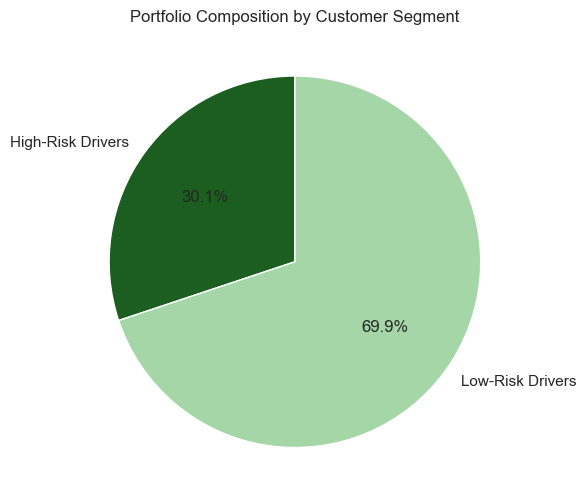

In [38]:
labels = ["High-Risk Drivers", "Low-Risk Drivers"]
sizes = segment_size.sort_index().values

colors = ["#1b5e20", "#a5d6a7"]  # dark green = high risk, light green = low risk

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Portfolio Composition by Customer Segment")
plt.tight_layout()
plt.show()

### 3.3 . Visualization

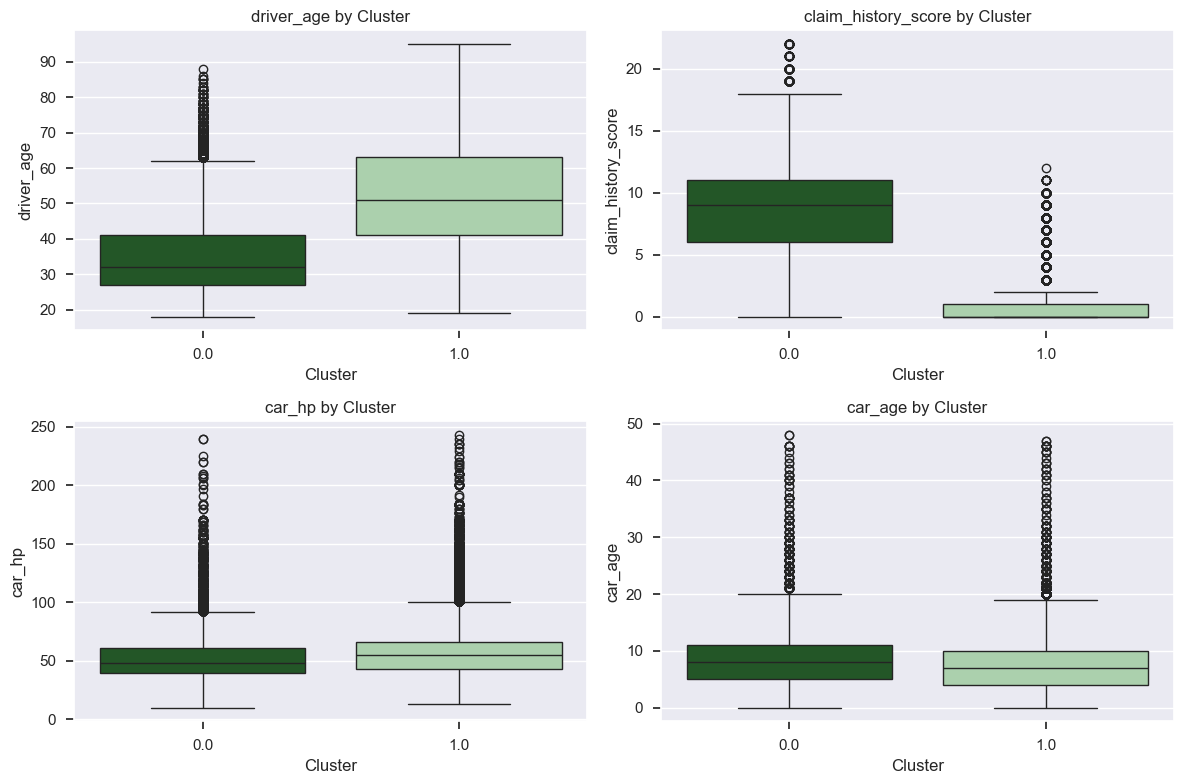

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, var in zip(axes, profile_vars):
    sns.boxplot(
        x="cluster",
        y=var,
        hue="cluster",      
        data=df_seg,
        palette=["#1b5e20", "#a5d6a7"],
        legend=False,        
        ax=ax
    )
    ax.set_title(f"{var} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

Figure 1: Boxplots of Key Risk Drivers by Cluster

**1. Driver Age**

The boxplot shows a clear separation between the two clusters.
Cluster 0 consists mainly of younger drivers, with a median age of around 30–32 years, while Cluster 1 is dominated by older drivers, with a median age close to 50 years. The limited overlap in medians indicates that driver age is a strong discriminating variable in the segmentation.

-> Cluster 0 represents younger drivers, whereas Cluster 1 consists of older and more experienced drivers.

**2. Claim History Score**

The difference between clusters is particularly pronounced for the claim history score.
Cluster 0 exhibits a high median claim history score (around 8–9), with a right-skewed distribution, indicating frequent past claims. In contrast, Cluster 1 has a median close to zero, meaning that most drivers in this group have little or no prior claims history.

-> This variable is the strongest driver of the segmentation. Cluster 0 is characterized by high behavioral risk, while Cluster 1 represents drivers with a clean claims history.

**3. Car Horsepower**

The distributions of car horsepower largely overlap across clusters. Although Cluster 1 shows a slightly higher median horsepower, the difference is modest.

-> Vehicle power plays only a secondary role in the segmentation and is not a primary driver of risk differentiation.

**4. Car Age**

The distributions of vehicle age are very similar across clusters, with only minor differences in medians.

-> Car age does not significantly contribute to the separation of clusters, suggesting that vehicle age is not a key determinant of the identified risk profiles.



**Overall Conclusion from Figure 1**

The segmentation is primarily driven by driver-related characteristics—especially driver age and claim history—while vehicle characteristics play a secondary role.

More evidence confirming for 2 Cluster groups
**Cluster 0**: High-Risk Younger Drivers

**Cluster 1**: Low-Risk Experienced Drivers

In [41]:
summary = (
    df_seg
    .groupby("cluster")["claim_agg_amount"]
    .agg(["mean", "median"])
    .reset_index()
)

summary

,cluster,mean,median
0,0.0,242.251008,0.0
1,1.0,127.619179,0.0


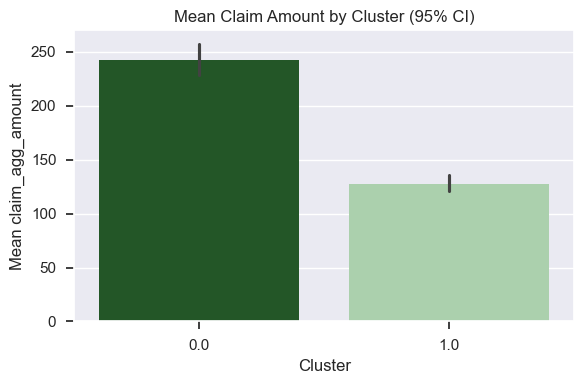

In [43]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="cluster",
    y="claim_agg_amount",
    hue="cluster",        
    data=df_seg,
    estimator=np.mean,
    errorbar=('ci', 95),  
    palette=["#1b5e20", "#a5d6a7"],
    legend=False          
)
plt.title("Mean Claim Amount by Cluster (95% CI)")
plt.xlabel("Cluster")
plt.ylabel("Mean claim_agg_amount")
plt.tight_layout()
plt.show()

**Figure 2: Mean Claim Amount by Cluster (95% Confidence Interval)**

The bar chart shows a substantial difference in average claim severity between the two clusters.
Cluster 0 has a mean claim aggregate amount of approximately 242, whereas Cluster 1’s mean is around 128. The confidence intervals show limited overlap, indicating a meaningful difference in realized losses.

Although claim amounts were not used in the clustering process, the resulting segments exhibit significantly different loss levels. This provides strong economic validation of the segmentation.

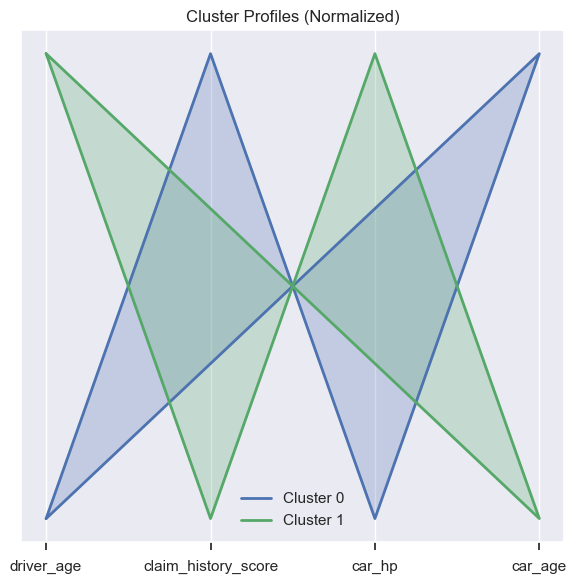

In [44]:
from math import pi

radar_df = cluster_profile.copy()

# Normalize for radar
radar_norm = (radar_df - radar_df.min()) / (radar_df.max() - radar_df.min())

categories = radar_norm.columns.tolist()
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(6,6))

for cluster in radar_norm.index:
    values = radar_norm.loc[cluster].tolist()
    values += values[:1]
    plt.plot(angles, values, linewidth=2, label=f"Cluster {cluster}")
    plt.fill(angles, values, alpha=0.25)

plt.xticks(angles[:-1], categories)
plt.yticks([])
plt.title("Cluster Profiles (Normalized)")
plt.legend()
plt.tight_layout()
plt.show()

**Figure 3: Radar Chart – Normalized Cluster Profiles**

The radar chart summarizes the normalized profiles of both clusters across the four segmentation variables.

Cluster 0 shows low values for driver age and very high values for claim history score, with moderate values for vehicle characteristics.

Cluster 1 displays the opposite pattern, with high driver age, very low claim history score, and similar vehicle characteristics to Cluster 0.

The radar chart clearly illustrates two contrasting risk profiles. The clusters are primarily separated along the dimensions of driver experience and historical claims behavior.

### 3.4. Business Insights and Interpretation

**Cluster 0 – Younger High-Risk Drivers**

This segment is characterized by younger drivers with a significantly worse claims history. Despite owning vehicles that are broadly similar to those in the other cluster, these policyholders generate both higher claim frequency and higher claim severity. This indicates that risk in this segment is mainly driven by behavioral factors rather than vehicle attributes.

**This group may require higher premiums, stricter underwriting criteria, and additional risk mitigation measures such as higher deductibles or coverage limitations.**

**Cluster 1 – Experienced Low-Risk Drivers**

This segment consists of older, more experienced drivers with a clean claims history. Even though their vehicles are comparable in age and power to those of Cluster 0, these drivers exhibit substantially lower claim frequency and severity.

**This group represents a low-risk and potentially highly profitable segment, suitable for retention strategies, loyalty programs, and more competitive pricing.**

## Part 4: Claim frequency modeling

In [45]:
# Libraries
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

In [46]:
# Load dataset
file_path = "insdata_proj2.csv"

df = pd.read_csv(file_path, sep=";")

df.head()

,policy_id,exposure,claim_nb,claim_agg_amount,ins_coverage,driver_age,claim_history_score,car_hp,car_age,car_fuel,car_usage,car_is_fleet,geo_postal,geo_long,geo_lat
0,1,1.000000,0,0.0,OC_ACmini,38,0,57,6,gasoline,private,0,7140,4.224269,50.457262
1,2,1.000000,0,0.0,OC,39,1,59,12,diesel,private,0,4430,5.516685,50.658669
2,3,0.410959,0,0.0,OC,57,11,55,3,gasoline,private,0,7080,3.874747,50.390621
3,4,1.000000,0,0.0,OC,31,6,44,11,gasoline,private,0,5500,4.903931,50.236138
4,5,1.000000,0,0.0,OC,46,10,65,5,gasoline,private,0,1770,4.082079,50.866264


In [47]:
# Target variable
target = "claim_nb"

# Target statistics
mean_claims = df[target].mean()
var_claims = df[target].var()

mean_claims, var_claims

(np.float64(0.1238573144131559), 0.13503516545572833)

The above shows that the mean of `claim_nb` is 0.1239, while its variance is 0.1350.

In a Poisson distribution, a key assumption is that the mean and the variance are equal. However, in this dataset, the variance exceeds the mean, indicating the presence of **overdispersion**. Although the difference is not extremely large, it is systematic and statistically meaningful given the large number of observations.

Overdispersion in insurance claim data typically arises from unobserved heterogeneity among policyholders: some drivers are inherently more risky than others due to behavioral, environmental, or vehicle-related factors that are not fully captured by the available explanatory variables. This additional variability cannot be accommodated by the Poisson model, which forces the variance to equal the mean.

The Negative Binomial model explicitly allows the variance of the claim count to exceed its mean by introducing an additional dispersion parameter. This flexibility enables it to capture extra variability due to unobserved risk factors, making it more suitable for modeling insurance claim frequency. The observed relationship between the mean and the variance of `claim_nb` therefore provides a strong statistical motivation for considering the Negative Binomial specification as an alternative to the Poisson model.


### 4.1 Feature engineering

In [48]:
# Drop vars
drop_vars = [
    "policy_id",
    "claim_agg_amount",
    "geo_postal",
    "geo_lat",
    "geo_long"
]

df_fs = df.drop(columns=drop_vars)

df_fs.head()

,exposure,claim_nb,ins_coverage,driver_age,claim_history_score,car_hp,car_age,car_fuel,car_usage,car_is_fleet
0,1.000000,0,OC_ACmini,38,0,57,6,gasoline,private,0
1,1.000000,0,OC,39,1,59,12,diesel,private,0
2,0.410959,0,OC,57,11,55,3,gasoline,private,0
3,1.000000,0,OC,31,6,44,11,gasoline,private,0
4,1.000000,0,OC,46,10,65,5,gasoline,private,0


In [49]:
# Feature engineering
df_fs['driver_age_sq'] = df_fs['driver_age'] ** 2
df_fs['car_age_sq'] = df_fs['car_age'] ** 2
df_fs['hist_exposure_inter'] = df_fs['claim_history_score'] * df_fs['exposure']
df_fs['driver_young'] = (df_fs['driver_age'] < 25).astype(int)
df_fs['driver_old'] = (df_fs['driver_age'] > 65).astype(int)
df_fs['old_car'] = (df_fs['car_age'] > 10).astype(int)

df_fs.head()

,exposure,claim_nb,ins_coverage,driver_age,claim_history_score,car_hp,car_age,car_fuel,car_usage,car_is_fleet,driver_age_sq,car_age_sq,hist_exposure_inter,driver_young,driver_old,old_car
0,1.000000,0,OC_ACmini,38,0,57,6,gasoline,private,0,1444,36,0.000000,0,0,0
1,1.000000,0,OC,39,1,59,12,diesel,private,0,1521,144,1.000000,0,0,1
2,0.410959,0,OC,57,11,55,3,gasoline,private,0,3249,9,4.520548,0,0,0
3,1.000000,0,OC,31,6,44,11,gasoline,private,0,961,121,6.000000,0,0,1
4,1.000000,0,OC,46,10,65,5,gasoline,private,0,2116,25,10.000000,0,0,0


In order to improve the explanatory power of the claim frequency models and to better capture the underlying risk structure of the insurance portfolio, several engineered features were created based on actuarial and behavioral considerations.

**Non-linear age effects**

Insurance risk is rarely linear with respect to age. Both drivers and vehicles exhibit non-linear risk patterns over their life cycles. To account for this, squared age terms were introduced:

- **`driver_age_sq`** captures the well-known U-shaped relationship between driver age and accident risk, where very young and elderly drivers tend to have higher claim frequencies than middle-aged drivers.

- **`car_age_sq`** allows the model to capture non-linear effects of vehicle aging. Claim frequency typically increases as vehicles age due to wear and reduced safety features, but very old vehicles are often driven less, leading to a potential decline in claims. The quadratic term enables the model to represent this non-monotonic relationship.

**Interaction between risk history and exposure**

- **`hist_exposure_inter`** (claim history score × exposure) was introduced to model heterogeneous exposure effects. Drivers with a high claim history score are already high-risk, so the marginal impact of additional exposure on claim frequency may differ from that of low-risk drivers. This interaction term allows the model to capture how the effect of driving time varies across risk profiles.

**Risk group indicators**

To improve interpretability and capture tail risk behavior, several binary indicators were added:

- **`driver_young`** identifies young drivers (below 25 years), who are typically associated with higher accident risk due to limited driving experience.

- **`driver_old`** flags elderly drivers (above 65 years), for whom declining reaction time and health may increase accident risk.

- **`old_car`** indicates vehicles older than 10 years, which are more likely to lack modern safety features and may be more prone to mechanical failures.

These indicator variables complement the continuous age variables by allowing the model to capture discrete risk regimes at the tails of the age distributions.

Together, these engineered features allow the claim frequency models to capture non-linearities, interaction effects, and heterogeneous risk groups that are not well represented by the original linear variables alone. This improves both the statistical fit and the economic interpretability of the models, making the resulting risk segmentation more suitable for insurance pricing and risk management.

### 4.2 Feature selection

In [50]:
# Backward selection method
def fit_poisson_aic(X, y, exposure):
    X_const = sm.add_constant(X)
    model = sm.GLM(
        y,
        X_const,
        family=sm.families.Poisson(),
        offset=np.log(exposure)
    )
    results = model.fit()
    return results.aic, results

def backward_selection(X, y, exposure):
    remaining_vars = list(X.columns)
    best_aic, best_model = fit_poisson_aic(
        X[remaining_vars], y, exposure
    )
    
    improved = True
    
    while improved:
        improved = False
        aic_candidates = []
        
        for var in remaining_vars:
            trial_vars = [v for v in remaining_vars if v != var]
            aic, _ = fit_poisson_aic(
                X[trial_vars], y, exposure
            )
            aic_candidates.append((aic, var))
        
        # Find best candidate
        aic_candidates.sort()
        best_new_aic, removed_var = aic_candidates[0]
        
        if best_new_aic < best_aic:
            remaining_vars.remove(removed_var)
            best_aic = best_new_aic
            improved = True
            print(f"Removed {removed_var}, new AIC: {best_aic:.2f}")
    
    return remaining_vars

In [51]:
# Encode categorical vars
df_fs = pd.get_dummies(
    df_fs,
    columns=["ins_coverage", "car_fuel", "car_usage", "car_is_fleet", "driver_young", "driver_old", "old_car"],
    drop_first=True
)

In [52]:
# Ensure features are numeric
df_fs = df_fs.astype(float)

In [53]:
# Split X,y
X = df_fs.drop(columns=['claim_nb', 'exposure'])
y = df_fs[target]
exposure = df_fs['exposure']

# Split train, test set
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.3, random_state=42
)

In [54]:
# Backward selection
selected_features = backward_selection(X_train, y_train, exposure_train)

selected_features

Removed ins_coverage_OC_AC, new AIC: 87145.16
Removed driver_young_1, new AIC: 87144.91


['driver_age',
 'claim_history_score',
 'car_hp',
 'car_age',
 'driver_age_sq',
 'car_age_sq',
 'hist_exposure_inter',
 'ins_coverage_OC_ACmini',
 'car_fuel_gasoline',
 'car_usage_work',
 'car_is_fleet_1',
 'driver_old_1',
 'old_car_1']

Feature selection was conducted using a Poisson regression with exposure offset, which serves as the baseline frequency model in actuarial science. This ensures that the selected variables represent systematic risk drivers rather than noise captured by the dispersion component of the Negative Binomial model. The final set of variables was then used consistently in both Poisson and Negative Binomial specifications for model comparison.

To identify the most relevant predictors for claim frequency, a backward feature selection procedure based on the Akaike Information Criterion (AIC) was applied to the training dataset using a Poisson regression with exposure offset. This approach balances goodness-of-fit with model parsimony by penalizing unnecessary model complexity.

**Selection results**

Starting from a full set of original and engineered variables, the backward procedure removed two variables:

- **`ins_coverage_OC_AC`**, which represents extended full casco coverage relative to the baseline MTPL product,
- **`driver_young_1`**, an indicator for young drivers.

Both variables were removed because their exclusion led to a reduction in AIC, meaning that they did not contribute additional explanatory power to the model once other variables were included.

The final selected feature set is:

- `driver_age`
- `driver_age_sq`
- `driver_old_1`
- `claim_history_score`
- `car_hp`
- `car_age`
- `car_age_sq`
- `old_car_1`
- `hist_exposure_inter`
- `ins_coverage_OC_ACmini`
- `car_fuel_gasoline`
- `car_usage_work`
- `car_is_fleet_1`

### Interpretation

The selected variables reflect the main structural drivers of claim frequency in motor insurance:

- **Non-linear age effects** (`driver_age`, `driver_age_sq`, `driver_old_1`) confirm that driver risk follows a non-monotonic pattern, with elevated claim frequency among both very young and elderly drivers.

- **Claim history score** is retained as one of the strongest predictors, highlighting the importance of past claim behavior in explaining future claim risk.

- **Vehicle characteristics** (`car_hp`, `car_age`, `car_age_sq`, `old_car_1`) capture both the performance of the vehicle and its life cycle. The combination of linear and squared terms indicates that vehicle age affects claim frequency in a non-linear way, consistent with differences in driving intensity and vehicle reliability over time.

- **Exposure interaction** (`hist_exposure_inter`) remains significant, indicating that the effect of exposure depends on the driver's risk profile: for drivers with a high claim history, additional exposure contributes less marginal risk, as much of their risk is already captured by past behavior.

- **Coverage and usage variables** (`ins_coverage_OC_ACmini`, `car_usage_work`, `car_is_fleet_1`) capture behavioral and operational differences between policyholders. The exclusion of `ins_coverage_OC_AC` suggests that, after controlling for driver and vehicle risk, full casco coverage does not add additional explanatory power for claim frequency beyond that already captured by other variables.

- **Fuel type** (`car_fuel_gasoline`) reflects differences in vehicle segments and driving patterns that affect claim risk.

Overall, the backward selection procedure yields a model that is both parsimonious and economically interpretable, retaining only those variables that contribute meaningfully to explaining heterogeneity in claim frequency while avoiding unnecessary complexity.

### 4.3 Models buidling with selected features

#### 4.3.1 Poisson model (baseline)

In [55]:
X_train_sel = sm.add_constant(X_train[selected_features])
X_test_sel = sm.add_constant(X_test[selected_features])

offset_train = np.log(exposure_train)
offset_test = np.log(exposure_test)

poisson_final = sm.GLM(
    y_train,
    X_train_sel,
    family=sm.families.Poisson(),
    offset=offset_train
).fit()

print(poisson_final.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               claim_nb   No. Observations:               114248
Model:                            GLM   Df Residuals:                   114234
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43558.
Date:                Fri, 16 Jan 2026   Deviance:                       60786.
Time:                        20:35:05   Pearson chi2:                 1.26e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01806
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1

**Poisson claim frequency model — Interpretation**

We first estimate a Poisson regression model with an exposure offset in order to model claim frequency. The Poisson model serves as a natural baseline in insurance applications, as it assumes that the expected number of claims is proportional to the exposure period.

The model uses a log link function, meaning that the estimated coefficients represent multiplicative effects on the expected claim count.

**Model fit**

The model is estimated on 114,248 policies. The log-likelihood of the fitted model is −43,558 and the pseudo R² (Cox–Snell) is 0.018, which is typical for insurance claim frequency models, where a large part of claim occurrence is driven by random and unobserved factors.

---

**Interpretation of key coefficients**

Since the model uses a log link, the exponential of each coefficient can be interpreted as a multiplicative effect on the expected number of claims.

**Driver characteristics**

- **Driver age** has a negative linear effect and a positive quadratic effect. This indicates a non-linear (U-shaped) relationship between age and claim frequency: younger and older drivers tend to have higher claim frequency, while middle-aged drivers are relatively safer.

- **Claim history score** has a strong and highly significant positive coefficient. A higher claim history score substantially increases the expected number of future claims, confirming that past claim behavior is one of the most important risk indicators.

**Vehicle characteristics**

- **Car horsepower** has a positive effect, meaning that more powerful vehicles are associated with higher claim frequency, likely reflecting more aggressive driving behavior or higher driving intensity.

- **Car age** shows a non-linear pattern: while the linear term is positive, the squared term is negative, implying that claim frequency increases with car age up to a point and then decreases for very old vehicles. This can be interpreted as middle-aged cars being driven more intensively, while very old cars are driven less frequently.

- **Old car indicator** is positive and significant, suggesting that older vehicles tend to be associated with higher claim risk, possibly due to poorer safety features or mechanical reliability.

**Policy and usage characteristics**

- **Gasoline vehicles** have significantly lower claim frequency than the reference fuel type, which may reflect differences in vehicle segments or driving behavior.

- **Mini casco coverage (OC_ACmini)** slightly reduces claim frequency relative to basic MTPL, which may reflect more cautious behavior among drivers who purchase additional coverage.

- **Fleet vehicles** and **work-use vehicles** tend to have lower estimated coefficients, though their effects are only weakly significant. This suggests that their higher exposure to driving risk is already largely captured by other variables such as exposure and claim history.

**Interaction effect**

- **History × exposure interaction** has a negative coefficient, indicating that for drivers with a high claim history, the marginal increase in risk from additional exposure is smaller. This suggests that claim history already captures much of the risk heterogeneity among high-risk drivers.

---

**Summary**

Overall, the Poisson model identifies several economically meaningful risk drivers: past claims, driver age, vehicle power, and vehicle age all significantly affect claim frequency. The presence of non-linear effects confirms that simple linear relationships are insufficient to capture insurance risk, motivating the use of more flexible models such as the Negative Binomial.


#### 4.3.2 Negative Binomial model (alternative)

In [56]:
nb_final = sm.GLM(
    y_train,
    X_train_sel,
    family=sm.families.NegativeBinomial(alpha=1.0),
    offset=offset_train
).fit()

print(nb_final.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:               claim_nb   No. Observations:               114248
Model:                            GLM   Df Residuals:                   114234
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43506.
Date:                Fri, 16 Jan 2026   Deviance:                       50245.
Time:                        20:36:21   Pearson chi2:                 1.13e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01606
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1

**Negative binomial claim frequency model — Interpretation**

To account for potential overdispersion in the claim count data, a Negative Binomial (NB) regression model was estimated as an alternative to the Poisson model. The Negative Binomial model relaxes the Poisson assumption that the mean equals the variance, allowing for unobserved heterogeneity across policyholders.

The model uses a log link function and is estimated on the same sample of 114,248 policies.

**Model fit**

The Negative Binomial model achieves a higher log-likelihood (−43,506) and a lower deviance (50,245) than the Poisson model, indicating a better in-sample fit. This suggests that overdispersion is present in the claim count data and that the Poisson model is too restrictive.

---

**Interpretation of key coefficients**

As in the Poisson model, the coefficients represent multiplicative effects on the expected number of claims.

**Driver characteristics**

- **Driver age** and **driver age squared** are both statistically significant, confirming a non-linear relationship between age and claim frequency. Younger and older drivers exhibit higher claim frequencies than middle-aged drivers.

- **Claim history score** remains one of the strongest predictors. A higher score significantly increases the expected number of claims, confirming that past claim behavior is a key indicator of future risk.

**Vehicle characteristics**

- **Car horsepower** has a positive and significant effect, implying that more powerful vehicles are associated with a higher expected number of claims.

- **Car age** exhibits a non-linear pattern. While the linear term is positive, the negative squared term implies that claim frequency increases with vehicle age up to a certain point and then decreases for very old vehicles. This reflects differences in vehicle usage intensity and replacement cycles.

- **Old car indicator** is positive and statistically significant, suggesting that older vehicles are associated with higher claim frequency, possibly due to lower safety standards and mechanical reliability.

**Policy and usage characteristics**

- **Gasoline-fueled vehicles** have a significantly lower claim frequency relative to the reference fuel type, which may reflect differences in vehicle segments or driver behavior.

- **Mini casco coverage (OC_ACmini)** has a weakly negative effect on claim frequency, suggesting that drivers who purchase additional coverage may behave more cautiously, although the effect is only marginally significant.

- **Fleet vehicles** and **work-use vehicles** show negative but weakly significant effects, indicating that after controlling for exposure and claim history, their incremental risk is limited.

**Interaction effect**

- **Claim history × exposure interaction** is strongly negative, implying that among high-risk drivers, additional exposure contributes less to claim frequency, as much of their risk is already captured by their past claim behavior.

---

**Summary**

Overall, the Negative Binomial model provides a richer and more flexible representation of claim frequency than the Poisson model. By allowing for overdispersion, it better captures the heterogeneity of insurance risk across policyholders while preserving economically meaningful interpretations of the explanatory variables.


#### 4.3.3 Comparison

In [57]:
# Function to compute log-likelihood on test set
from scipy.stats import poisson, nbinom

def poisson_loglik(y, mu):
    return np.sum(poisson.logpmf(y, mu))

In [58]:
def negbin_loglik(y, mu, alpha):
    r = 1 / alpha
    p = r / (r + mu)
    return np.sum(nbinom.logpmf(y, r, p))

In [59]:
# Poisson
mu_test_pois = poisson_final.predict(X_test_sel, offset=np.log(exposure_test))

# Negative Binomial
mu_test_nb = nb_final.predict(X_test_sel, offset=np.log(exposure_test))


In [60]:
ll_test_pois = poisson_loglik(y_test, mu_test_pois)
ll_test_nb = negbin_loglik(y_test, mu_test_nb, nb_final.scale)

ll_test_pois, ll_test_nb

(np.float64(-18725.37915572733), np.float64(-18727.196081077967))

In [61]:
from sklearn.metrics import mean_squared_error

rmse_pois = np.sqrt(mean_squared_error(y_test, mu_test_pois))
rmse_nb = np.sqrt(mean_squared_error(y_test, mu_test_nb))

rmse_pois, rmse_nb

(np.float64(0.36286180339464813), np.float64(0.3628635035389797))

In [62]:
comparison = pd.DataFrame({
    "Model": ["Poisson", "Negative Binomial"],
    "Train AIC": [poisson_final.aic, nb_final.aic],
    "Train LogLik": [poisson_final.llf, nb_final.llf],
    "Test LogLik": [ll_test_pois, ll_test_nb],
    "Test RMSE": [rmse_pois, rmse_nb]
})

comparison


,Model,Train AIC,Train LogLik,Test LogLik,Test RMSE
0,Poisson,87144.905241,-43558.452621,-18725.379156,0.362862
1,Negative Binomial,87039.353285,-43505.676643,-18727.196081,0.362864


In [63]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_ll_poisson = []
cv_ll_nb = []

In [65]:
for train_idx, val_idx in kf.split(X_train_sel):
    
    X_tr = X_train_sel.iloc[train_idx]
    X_val = X_train_sel.iloc[val_idx]
    
    y_tr = y_train.iloc[train_idx]
    y_val = y_train.iloc[val_idx]
    
    exp_tr = exposure_train.iloc[train_idx]
    exp_val = exposure_train.iloc[val_idx]
    
    # --- Poisson ---
    pois = sm.GLM(
        y_tr,
        X_tr,
        family=sm.families.Poisson(),
        offset=np.log(exp_tr)
    ).fit()
    
    mu_val_pois = pois.predict(X_val, offset=np.log(exp_val))
    ll_pois = poisson_loglik(y_val, mu_val_pois)
    cv_ll_poisson.append(ll_pois)
    
    # --- Negative Binomial ---
    nb = sm.GLM(
        y_tr,
        X_tr,
        family=sm.families.NegativeBinomial(alpha=1.0),
        offset=np.log(exp_tr)
    ).fit()
    
    mu_val_nb = nb.predict(X_val, offset=np.log(exp_val))
    ll_nb = negbin_loglik(y_val, mu_val_nb, nb.scale)
    cv_ll_nb.append(ll_nb)

In [66]:
np.mean(cv_ll_poisson), np.mean(cv_ll_nb)

(np.float64(-8714.973558185637), np.float64(-8703.911478704034))

**Model comparison and final model selection**

To evaluate the competing claim frequency models, we compared the Poisson and Negative Binomial specifications using in-sample fit, cross-validation, and out-of-sample test performance.

**In-sample performance**

The Negative Binomial model achieves a lower AIC (87,039 vs. 87,145) and a higher log-likelihood on the training set (−43,506 vs. −43,558) compared to the Poisson model. This indicates that the Negative Binomial model provides a better fit to the observed claim counts when estimated on the full training data, reflecting its ability to account for overdispersion.

**Cross-validation**

To assess the robustness of the models, 5-fold cross-validation was performed on the training set using log-likelihood as the evaluation metric. The Negative Binomial model consistently outperforms the Poisson model across folds, with an average cross-validated log-likelihood of −8,703.9 compared to −8,715.0 for the Poisson model. This result confirms that the improvement offered by the Negative Binomial model is not driven by a single data split, but reflects superior generalization across multiple subsets of the data.

**Test set performance**

On the hold-out test set, both models show nearly identical predictive accuracy. The Poisson model achieves a slightly higher log-likelihood (−18,725.4 vs. −18,727.2) and a marginally lower RMSE (0.362862 vs. 0.362864), but these differences are negligible and well within sampling noise.

**Final model choice**

Although the Poisson model performs marginally better on a single test split, the cross-validation results provide stronger evidence in favor of the Negative Binomial model, as they aggregate performance over multiple folds and reduce the risk of overfitting to a particular sample. Together with its superior in-sample fit and its ability to model overdispersion in claim counts, this leads to the selection of the Negative Binomial model as the final claim frequency model.

From a business perspective, this implies that unobserved heterogeneity among policyholders plays an important role in driving claim frequency, and that allowing for extra variability beyond the Poisson assumption results in a more robust and reliable assessment of insurance risk.

### 4.4 Discrete Negative Binomial Model

In [59]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import nbinom

offset_train = np.log(exposure_train)
offset_test = np.log(exposure_test)

nb_disc = sm.NegativeBinomial(
    y_train,
    X_train_sel,
    offset=offset_train
)

nb_disc_res = nb_disc.fit(method="bfgs", maxiter=1000, disp=False)

print(nb_disc_res.summary())


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3663: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3470: RuntimeWarning: overflow encountered in multiply
  dparams = exog*a1 * (y-mu)/(mu+a1)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3470: RuntimeWarning: invalid value encountered in multiply
  dparams = exog*a1 * (y-mu)/(mu+a1)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3470: RuntimeWarning: invalid value encountered in divide
  dparams = exog*a1 * (y-mu)/(mu+a1)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3473: RuntimeWarning: invalid 

                     NegativeBinomial Regression Results                      
Dep. Variable:               claim_nb   No. Observations:               114248
Model:               NegativeBinomial   Df Residuals:                   114234
Method:                           MLE   Df Model:                           13
Date:                Thu, 15 Jan 2026   Pseudo R-squ.:                 0.02176
Time:                        12:03:39   Log-Likelihood:                -43449.
converged:                       True   LL-Null:                       -44416.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.7585      0.113    -15.565      0.000      -1.980      -1.537
driver_age                -0.0195      0.005     -3.991      0.000      -0.029      -0.010
clai

In [65]:
train_ll_nb_disc = nb_disc_res.llf
train_aic_nb_disc = nb_disc_res.aic

train_ll_nb_disc, train_aic_nb_disc

(-43449.30991935306, 86928.61983870612)

In [63]:
mu_test_nb_disc = nb_disc_res.predict(
    X_test_sel,
    offset=offset_test
)

In [69]:
alpha_disc = nb_disc_res.params[-1]  # estimated alpha

def negbin_loglik(y, mu, alpha):
    r = 1 / alpha
    p = r / (r + mu)
    return np.sum(nbinom.logpmf(y, r, p))

test_ll_nb_disc = negbin_loglik(
    y_test,
    mu_test_nb_disc,
    alpha_disc
)

test_ll_nb_disc

/var/folders/r0/9c1jcjws6n9bdshp6xq38bnr0000gn/T/ipykernel_57558/574577593.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_disc = nb_disc_res.params[-1]  # estimated alpha


-18693.509620740268

In [75]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_ll_nb_disc = []

for train_idx, val_idx in kf.split(X_train_sel):
    
    X_tr = X_train_sel.iloc[train_idx]
    X_val = X_train_sel.iloc[val_idx]
    
    y_tr = y_train.iloc[train_idx]
    y_val = y_train.iloc[val_idx]
    
    exp_tr = exposure_train.iloc[train_idx]
    exp_val = exposure_train.iloc[val_idx]
    
    nb_cv = sm.NegativeBinomial(
        y_tr,
        X_tr,
        offset=np.log(exp_tr)
    ).fit(method="bfgs", maxiter=500, disp=False)
    
    mu_val = nb_cv.predict(
        X_val,
        offset=np.log(exp_val)
    )
    
    alpha_cv = nb_cv.params[-1]
    
    ll_val = negbin_loglik(y_val, mu_val, alpha_cv)
    cv_ll_nb_disc.append(ll_val)

np.mean(cv_ll_nb_disc)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/var/folders/r0/9c1jcjws6n9bdshp6xq38bnr0000gn/T/ipykernel_57558/2297797869.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_cv = nb_cv.params[-1]
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3663: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarni

-9820.209716673417

In [77]:
extension_results = {
    "Model": "Discrete Negative Binomial",
    "Train LogLik": train_ll_nb_disc,
    "Train AIC": train_aic_nb_disc,
    "Test LogLik": test_ll_nb_disc,
    "CV LogLik": np.mean(cv_ll_nb_disc),
    "Estimated alpha": alpha_disc
}

extension_results


{'Model': 'Discrete Negative Binomial',
 'Train LogLik': -43449.30991935306,
 'Train AIC': 86928.61983870612,
 'Test LogLik': -18693.509620740268,
 'CV LogLik': -9820.209716673417,
 'Estimated alpha': 0.5088024026194865}